# [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration)

## コンペについて
このコンテストでは、Kaggleはニューヨーク市でのタクシー旅行の合計乗車時間を予測するモデルを作成するように挑戦しています。プライマリデータセットは、ニューヨークタクシーアンドリムジンコミッションによってリリースされたもので、ピックアップ時間、地理座標、乗客数、およびその他のいくつかの変数が含まれています。

## データについて
- 説明変数
  - id-各旅行の一意の識別子
  - vendor_id-旅行レコードに関連付けられたプロバイダーを示すコード
  - Pickup_datetime-メーターが使用された日時
  - dropoff_datetime-メーターが外された日時
  - passenger_count-車両の乗客数（ドライバーが入力した値）
  - Pickup_longitude-メーターが使用された経度
  - Pickup_latitude-メーターが使用された緯度
  - dropoff_longitude-メーターが外された経度
  - dropoff_latitude-メーターが外れた緯度
  - store_and_fwd_flag-このフラグは、車両にサーバーへの接続がなかったため、ベンダーに送信する前にトリップレコードが車両のメモリに保持されたかどうかを示します-Y =保存して転送。N =保存も転送もなし。
- 目的変数
  - trip_duration-秒単位の旅行の所要時間
  
## 評価について
実際の所要時間と予測した所要時間の対数平方平均二乗誤差。

データの提出形式は以下の通り。
```
id、trip_duration 
id00001,978 
id00002,978 
id00003,978 
id00004,978 
:
```

## 参照したノートブック
### [Yellow Cabs tell The Story of New York City](https://www.kaggle.com/selfishgene/yellow-cabs-tell-the-story-of-new-york-city)

このスクリプトでは、タクシーの使用状況を調べることで推測できる、ニューヨークの人々の空間的および時間的な行動を探ります。\
このデータセットの主なフィールドは、タクシーの乗車時刻と場所、および降車場所と旅行時間です。\
2016年の前半に発生したデータセットには、合計で約140万回のトリップがあります。\
キャブの使用パターンが1年、1週間、1日を通してどのように変化するかを確認し、平日と週末の違いに注目します。

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn import decomposition
from scipy import stats
from sklearn import cluster

matplotlib.style.use('fivethirtyeight')
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (10,10)

##### データを読み込み、明らかな外れ値を削除し、すべてを適切な単位に変換します

In [2]:
dataDir = ''
taxiDB = pd.read_csv(dataDir + 'train.csv')

# remove obvious outliers
allLat  = np.array(list(taxiDB['pickup_latitude'])  + list(taxiDB['dropoff_latitude']))
allLong = np.array(list(taxiDB['pickup_longitude']) + list(taxiDB['dropoff_longitude']))

longLimits = [np.percentile(allLong, 0.3), np.percentile(allLong, 99.7)]
latLimits  = [np.percentile(allLat , 0.3), np.percentile(allLat , 99.7)]
durLimits  = [np.percentile(taxiDB['trip_duration'], 0.4), np.percentile(taxiDB['trip_duration'], 99.7)]

taxiDB = taxiDB[(taxiDB['pickup_latitude']   >= latLimits[0] ) & (taxiDB['pickup_latitude']   <= latLimits[1]) ]
taxiDB = taxiDB[(taxiDB['dropoff_latitude']  >= latLimits[0] ) & (taxiDB['dropoff_latitude']  <= latLimits[1]) ]
taxiDB = taxiDB[(taxiDB['pickup_longitude']  >= longLimits[0]) & (taxiDB['pickup_longitude']  <= longLimits[1])]
taxiDB = taxiDB[(taxiDB['dropoff_longitude'] >= longLimits[0]) & (taxiDB['dropoff_longitude'] <= longLimits[1])]
taxiDB = taxiDB[(taxiDB['trip_duration']     >= durLimits[0] ) & (taxiDB['trip_duration']     <= durLimits[1]) ]
taxiDB = taxiDB.reset_index(drop=True)

allLat  = np.array(list(taxiDB['pickup_latitude'])  + list(taxiDB['dropoff_latitude']))
allLong = np.array(list(taxiDB['pickup_longitude']) + list(taxiDB['dropoff_longitude']))

# convert fields to sensible units
medianLat  = np.percentile(allLat,50)
medianLong = np.percentile(allLong,50)

latMultiplier  = 111.32 # 緯度1度あたりの距離(km)
longMultiplier = np.cos(medianLat*(np.pi/180.0)) * 111.32 # 経度1度あたりの距離(km)

taxiDB['duration [min]'] = taxiDB['trip_duration']/60.0
taxiDB['src lat [km]']   = latMultiplier  * (taxiDB['pickup_latitude']   - medianLat)
taxiDB['src long [km]']  = longMultiplier * (taxiDB['pickup_longitude']  - medianLong)
taxiDB['dst lat [km]']   = latMultiplier  * (taxiDB['dropoff_latitude']  - medianLat)
taxiDB['dst long [km]']  = longMultiplier * (taxiDB['dropoff_longitude'] - medianLong)

allLat  = np.array(list(taxiDB['src lat [km]'])  + list(taxiDB['dst lat [km]']))
allLong = np.array(list(taxiDB['src long [km]']) + list(taxiDB['dst long [km]']))

In [3]:
taxiDB

id  vendor_id      pickup_datetime     dropoff_datetime  \
0        id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1        id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2        id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3        id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4        id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   
...            ...        ...                  ...                  ...   
1420053  id2376096          2  2016-04-08 13:31:04  2016-04-08 13:44:02   
1420054  id1049543          1  2016-01-10 07:35:15  2016-01-10 07:46:10   
1420055  id2304944          2  2016-04-22 06:57:41  2016-04-22 07:10:25   
1420056  id2714485          1  2016-01-05 15:56:26  2016-01-05 16:02:39   
1420057  id1209952          1  2016-04-05 14:44:25  2016-04-05 14:47:43   

         passenger_count  pickup_longitude  pickup_latitude  \
0                      1        -73.982155        40.767937   
1                      1        -73.980415        40.738564   
2                      1        -73.979027        40.763939   
3                      1        -74.010040        40.719971   
4                      1        -73.973053        40.793209   
...                  ...               ...              ...   
1420053                4        -73.982201        40.745522   
1420054                1        -74.000946        40.747379   
1420055                1        -73.959129        40.768799   
1420056                1        -73.982079        40.749062   
1420057                1        -73.979538        40.781750   

         dropoff_longitude  dropoff_latitude store_and_fwd_flag  \
0               -73.964630         40.765602                  N   
1               -73.999481         40.731152                  N   
2               -74.005333         40.710087                  N   
3               -74.012268         40.706718                  N   
4               -73.972923         40.782520                  N   
...                    ...               ...                ...   
1420053         -73.994911         40.740170                  N   
1420054         -73.970184         40.796547                  N   
1420055         -74.004433         40.707371                  N   
1420056         -73.974632         40.757107                  N   
1420057         -73.972809         40.790585                  N   

         trip_duration  duration [min]  src lat [km]  src long [km]  \
0                  455        7.583333      1.486707      -0.099721   
1                  663       11.050000     -1.783114       0.046965   
2                 2124       35.400000      1.041672       0.164056   
3                  429        7.150000     -3.852868      -2.451197   
4                  435        7.250000      4.300027       0.667806   
...                ...             ...           ...            ...   
1420053            778       12.966667     -1.008549      -0.103581   
1420054            655       10.916667     -0.801743      -1.684313   
1420055            764       12.733333      1.582678       1.841936   
1420056            373        6.216667     -0.614472      -0.093287   
1420057            198        3.300000      3.024372       0.120951   

         dst lat [km]  dst long [km]  
0            1.226820       1.378075  
1           -2.608213      -1.560788  
2           -4.953142      -2.054245  
3           -5.328110      -2.639058  
4            3.110152       0.678744  
...               ...            ...  
1420053     -1.604336      -1.175417  
1420054      4.671598       0.909709  
1420055     -5.255494      -1.978328  
1420056      0.281120       0.534631  
1420057      4.007867       0.688394  

[1420058 rows x 16 columns]

##### 移動時間、緯度、経度の結果のヒストグラムをプロットします

Text(0.5, 0, 'longitude [km]')

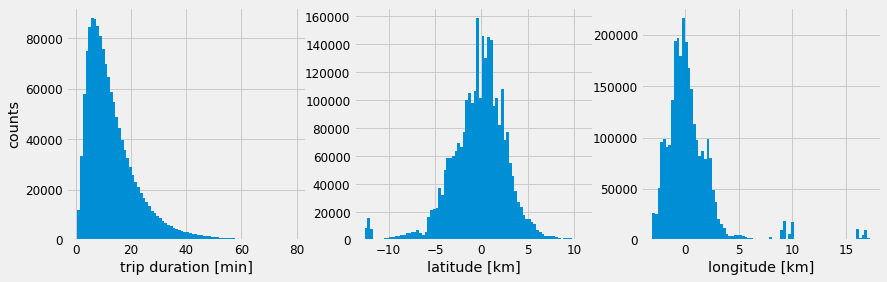

In [4]:
# make sure the ranges we chose are sensible
fig, axArray = plt.subplots(nrows=1,ncols=3,figsize=(13,4))
axArray[0].hist(taxiDB['duration [min]'],80); 
axArray[0].set_xlabel('trip duration [min]'); axArray[0].set_ylabel('counts')
axArray[1].hist(allLat ,80); axArray[1].set_xlabel('latitude [km]')
axArray[2].hist(allLong,80); axArray[2].set_xlabel('longitude [km]')

##### 移動時間とピックアップとドロップオフの間の空中距離をプロットします

Text(0.5, 1.0, 'log of trip Duration vs Aerial trip Distance')

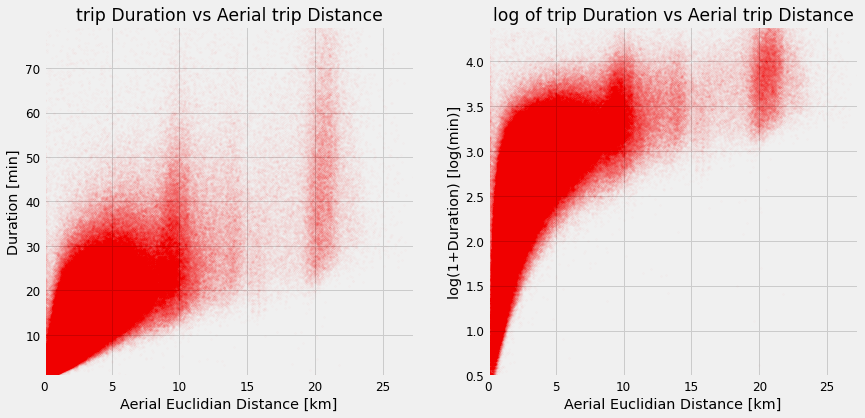

In [5]:
#%% plot scatter of trip duration vs. aerial distance between pickup and dropoff
taxiDB['log duration']       = np.log1p(taxiDB['duration [min]'])
taxiDB['euclidian distance'] = np.sqrt((taxiDB['src lat [km]']  - taxiDB['dst lat [km]'] )**2 + 
                                       (taxiDB['src long [km]'] - taxiDB['dst long [km]'])**2)

fig, axArray = plt.subplots(nrows=1,ncols=2,figsize=(13,6))
axArray[0].scatter(taxiDB['euclidian distance'], taxiDB['duration [min]'],c='r',s=5,alpha=0.01); 
axArray[0].set_xlabel('Aerial Euclidian Distance [km]'); axArray[0].set_ylabel('Duration [min]')
axArray[0].set_xlim(taxiDB['euclidian distance'].min(),taxiDB['euclidian distance'].max())
axArray[0].set_ylim(taxiDB['duration [min]'].min(),taxiDB['duration [min]'].max())
axArray[0].set_title('trip Duration vs Aerial trip Distance')

axArray[1].scatter(taxiDB['euclidian distance'], taxiDB['log duration'],c='r',s=5,alpha=0.01); 
axArray[1].set_xlabel('Aerial Euclidian Distance [km]'); axArray[1].set_ylabel('log(1+Duration) [log(min)]')
axArray[1].set_xlim(taxiDB['euclidian distance'].min(),taxiDB['euclidian distance'].max())
axArray[1].set_ylim(taxiDB['log duration'].min(),taxiDB['log duration'].max())
axArray[1].set_title('log of trip Duration vs Aerial trip Distance')

トリップ距離がトリップ期間の下限を定義していることがわかります。

##### ピックアップとドロップオフの位置の空間密度プロットをプロットする

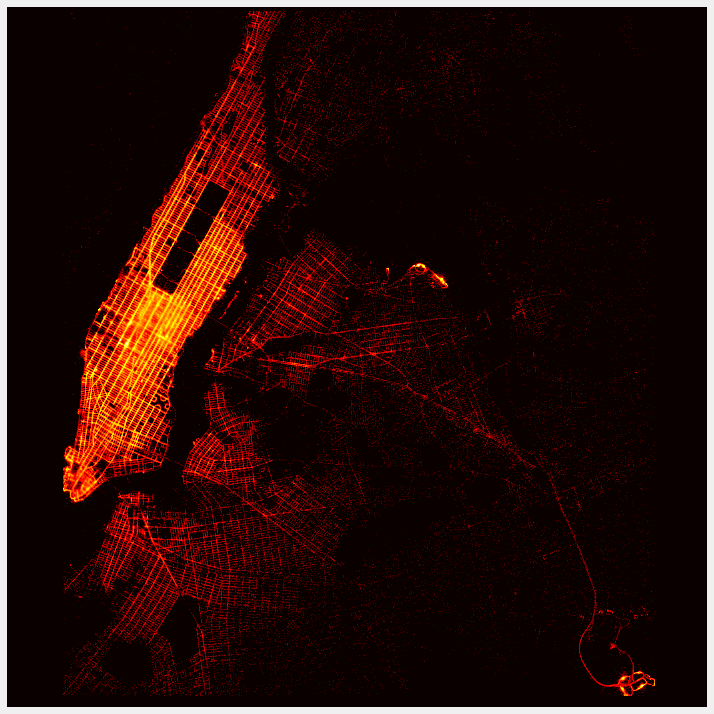

In [6]:
# show the log density of pickup and dropoff locations
imageSize = (700,700)
longRange = [-5,19]
latRange = [-13,11]

allLatInds  = imageSize[0] - (imageSize[0] * (allLat  - latRange[0])  / (latRange[1]  - latRange[0]) ).astype(int)
allLongInds =                (imageSize[1] * (allLong - longRange[0]) / (longRange[1] - longRange[0])).astype(int)

locationDensityImage = np.zeros(imageSize)
for latInd, longInd in zip(allLatInds,allLongInds):
    locationDensityImage[latInd,longInd] += 1

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,12))
ax.imshow(np.log(locationDensityImage+1),cmap='hot')
ax.set_axis_off()

いいね！マンハッタンと2つの空港が「空を照らしている」ので、宇宙から見ると予想されるものの少し見えます。

### 補足
ニューヨークの地図を知らないのでGoogleマップで検索。
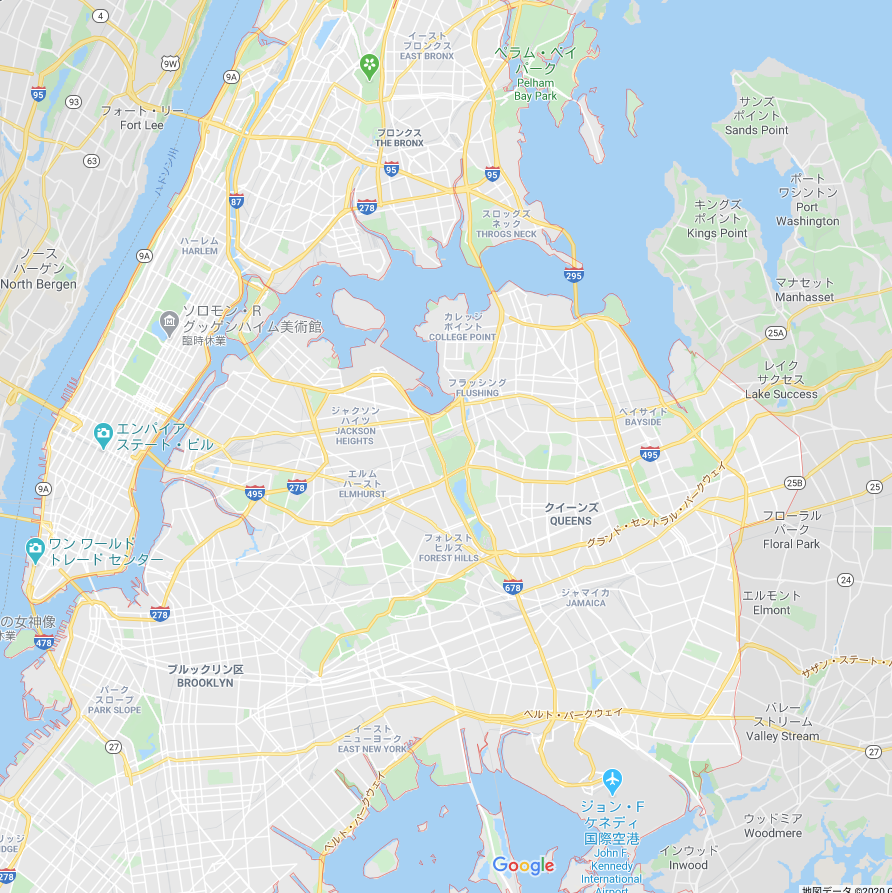

##### マンハッタンにズーム・イン！m9

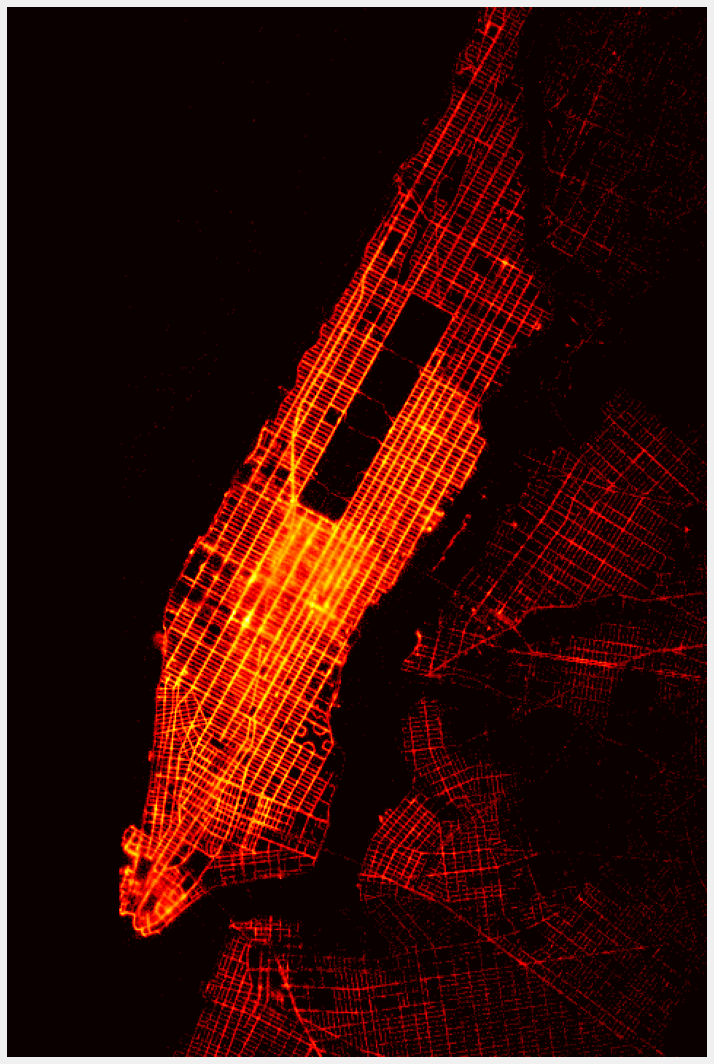

In [7]:
# zoom in on Manhattan 
imageSizeMan = (720,480)
latRangeMan = [-8,10]
longRangeMan = [-5,7]

indToKeep  = np.logical_and(allLat > latRangeMan[0], allLat < latRangeMan[1])
indToKeep  = np.logical_and(indToKeep, np.logical_and(allLong > longRangeMan[0], allLong < longRangeMan[1]))
allLatMan  = allLat[indToKeep]
allLongMan = allLong[indToKeep]

allLatIndsMan  = (imageSizeMan[0]-1) - (imageSizeMan[0] * (allLatMan  - latRangeMan[0])
                                                        / (latRangeMan[1] - latRangeMan[0])).astype(int)
allLongIndsMan =                       (imageSizeMan[1] * (allLongMan - longRangeMan[0])
                                                        / (longRangeMan[1] - longRangeMan[0])).astype(int)

locationDensityImageMan = np.zeros(imageSizeMan)
for latInd, longInd in zip(allLatIndsMan,allLongIndsMan):
    locationDensityImageMan[latInd,longInd] += 1

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,18))
ax.imshow(np.log(locationDensityImageMan+1),cmap='hot')
ax.set_axis_off()

##### 後で使用できるようにいくつかの有用なフィールドを作成する

In [8]:
#%% create some new usefull fields
pickupTime = pd.to_datetime(taxiDB['pickup_datetime'])

taxiDB['src hourOfDay'] = (pickupTime.dt.hour*60.0 + pickupTime.dt.minute)   / 60.0
taxiDB['dst hourOfDay'] = taxiDB['src hourOfDay'] + taxiDB['duration [min]'] / 60.0

taxiDB['dayOfWeek']     = pickupTime.dt.weekday
taxiDB['hourOfWeek']    = taxiDB['dayOfWeek']*24.0 + taxiDB['src hourOfDay']

taxiDB['monthOfYear']   = pickupTime.dt.month
taxiDB['dayOfYear']     = pickupTime.dt.dayofyear
taxiDB['weekOfYear']    = pickupTime.dt.weekofyear
taxiDB['hourOfYear']    = taxiDB['dayOfYear']*24.0 + taxiDB['src hourOfDay']

In [9]:
taxiDB

id  vendor_id      pickup_datetime     dropoff_datetime  \
0        id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1        id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2        id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3        id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4        id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   
...            ...        ...                  ...                  ...   
1420053  id2376096          2  2016-04-08 13:31:04  2016-04-08 13:44:02   
1420054  id1049543          1  2016-01-10 07:35:15  2016-01-10 07:46:10   
1420055  id2304944          2  2016-04-22 06:57:41  2016-04-22 07:10:25   
1420056  id2714485          1  2016-01-05 15:56:26  2016-01-05 16:02:39   
1420057  id1209952          1  2016-04-05 14:44:25  2016-04-05 14:47:43   

         passenger_count  pickup_longitude  pickup_latitude  \
0                      1        -73.982155        40.767937   
1                      1        -73.980415        40.738564   
2                      1        -73.979027        40.763939   
3                      1        -74.010040        40.719971   
4                      1        -73.973053        40.793209   
...                  ...               ...              ...   
1420053                4        -73.982201        40.745522   
1420054                1        -74.000946        40.747379   
1420055                1        -73.959129        40.768799   
1420056                1        -73.982079        40.749062   
1420057                1        -73.979538        40.781750   

         dropoff_longitude  dropoff_latitude store_and_fwd_flag  ...  \
0               -73.964630         40.765602                  N  ...   
1               -73.999481         40.731152                  N  ...   
2               -74.005333         40.710087                  N  ...   
3               -74.012268         40.706718                  N  ...   
4               -73.972923         40.782520                  N  ...   
...                    ...               ...                ...  ...   
1420053         -73.994911         40.740170                  N  ...   
1420054         -73.970184         40.796547                  N  ...   
1420055         -74.004433         40.707371                  N  ...   
1420056         -73.974632         40.757107                  N  ...   
1420057         -73.972809         40.790585                  N  ...   

         log duration  euclidian distance  src hourOfDay  dst hourOfDay  \
0            2.149822            1.500473      17.400000      17.526389   
1            2.489065            1.807114       0.716667       0.900833   
2            3.594569            6.392077      11.583333      12.173333   
3            2.098018            1.487155      19.533333      19.652500   
4            2.110213            1.189925      13.500000      13.620833   
...               ...                 ...            ...            ...   
1420053      2.636674            1.226293      13.516667      13.732778   
1420054      2.477938            6.056931       7.583333       7.765278   
1420055      2.619826            7.832945       6.950000       7.162222   
1420056      1.976393            1.093785      15.933333      16.036944   
1420057      1.458615            1.135452      14.733333      14.788333   

         dayOfWeek  hourOfWeek  monthOfYear  dayOfYear  weekOfYear  \
0                0   17.400000            3         74          11   
1                6  144.716667            6        164          23   
2                1   35.583333            1         19           3   
3                2   67.533333            4         97          14   
4                5  133.500000            3         86          12   
...            ...         ...          ...        ...         ...   
1420053          4  109.516667            4         99          14   
1420054          6  151.583333  

##### 旅行をクラスター化して分布を確認する

すべての旅行は、基本的に5つの主要な属性で構成されています：乗車場所と降車場所、および旅行期間。 140万回の旅行すべてを80の定型的なテンプレート旅行にクラスタリングしてから、この「旅行のバッグ」の分布とそれが時間とともにどのように変化するかを見てみましょう

(0.0, 81.0)

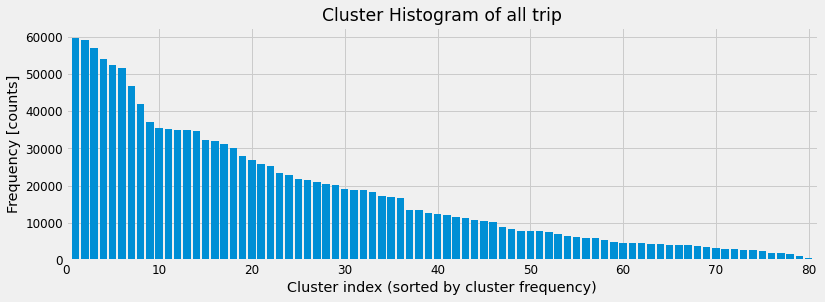

In [10]:
tripAttributes = np.array(taxiDB.loc[:,['src lat [km]','src long [km]','dst lat [km]','dst long [km]','duration [min]']])
meanTripAttr = tripAttributes.mean(axis=0)
stdTripAttr  = tripAttributes.std(axis=0)
tripAttributes = stats.zscore(tripAttributes, axis=0)

numClusters = 80
TripKmeansModel = cluster.MiniBatchKMeans(n_clusters=numClusters, batch_size=120000, n_init=100, random_state=1)
clusterInds = TripKmeansModel.fit_predict(tripAttributes)

clusterTotalCounts, _ = np.histogram(clusterInds, bins=numClusters)
sortedClusterInds = np.flipud(np.argsort(clusterTotalCounts))

plt.figure(figsize=(12,4)); plt.title('Cluster Histogram of all trip')
plt.bar(range(1,numClusters+1),clusterTotalCounts[sortedClusterInds])
plt.ylabel('Frequency [counts]'); plt.xlabel('Cluster index (sorted by cluster frequency)')
plt.xlim(0,numClusters+1)

##### 地図に典型的な旅行を表示する

マゼンタの円はソース、緑の円はデスティネーション、それらの間の矢印はシアンで描かれています

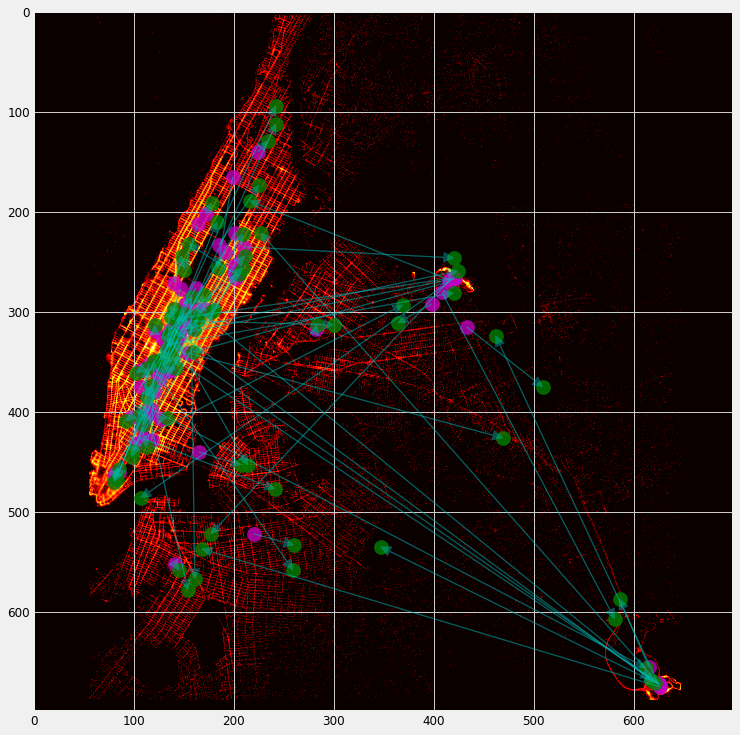

In [11]:
#%% show the templeate trips on the map
def ConvertToImageCoords(latCoord, longCoord, latRange, longRange, imageSize):
    latInds  = imageSize[0] - (imageSize[0] * (latCoord  - latRange[0])  / (latRange[1]  - latRange[0]) ).astype(int)
    longInds =                (imageSize[1] * (longCoord - longRange[0]) / (longRange[1] - longRange[0])).astype(int)

    return latInds, longInds

templateTrips = TripKmeansModel.cluster_centers_ * np.tile(stdTripAttr,(numClusters,1)) + np.tile(meanTripAttr,(numClusters,1))

srcCoords = templateTrips[:,:2]
dstCoords = templateTrips[:,2:4]

srcImCoords = ConvertToImageCoords(srcCoords[:,0],srcCoords[:,1], latRange, longRange, imageSize)
dstImCoords = ConvertToImageCoords(dstCoords[:,0],dstCoords[:,1], latRange, longRange, imageSize)

plt.figure(figsize=(12,12))
plt.imshow(np.log(locationDensityImage+1),cmap='hot'); plt.grid('off')
plt.scatter(srcImCoords[1],srcImCoords[0],c='m',s=200,alpha=0.8)
plt.scatter(dstImCoords[1],dstImCoords[0],c='g',s=200,alpha=0.8)

for i in range(len(srcImCoords[0])):
    plt.arrow(srcImCoords[1][i],srcImCoords[0][i], dstImCoords[1][i]-srcImCoords[1][i], dstImCoords[0][i]-srcImCoords[0][i], 
              edgecolor='c', facecolor='c', width=0.8,alpha=0.4,head_width=10.0,head_length=10.0,length_includes_head=True)

マゼンタの円はソース（ピックアップの場所）、緑の円は宛先（ドロップオフの場所）で、それらの間の矢印はシアンで描かれています。 マンハッタンの周辺が主に目的地として機能し、ソースと目的地の不均一な分布を見ることができます。 （ブルックリンとクイーンズを「周辺」と呼ぶために私を殺したいと思う人もいると思います...）

###### 次に、これらの旅行の時間的側面を調べてみましょう。

##### 1日のさまざまな時間のWeekDay Trip分布

この「旅行のバッグ」は、通常の勤務時間中にどのように変化しますか？

Text(58, 1.75, 'Silent Nights')

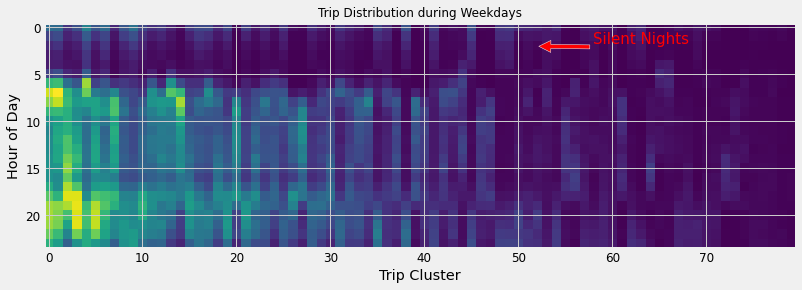

In [12]:
# calculate the trip distribution for different hours of the weekday
hoursOfDay = np.sort(taxiDB['src hourOfDay'].astype(int).unique())
clusterDistributionHourOfDay_weekday = np.zeros((len(hoursOfDay),numClusters))
for k, hour in enumerate(hoursOfDay):
    slectedInds = (taxiDB['src hourOfDay'].astype(int) == hour) & (taxiDB['dayOfWeek'] <= 4)
    currDistribution, _ = np.histogram(clusterInds[slectedInds], bins=numClusters)
    clusterDistributionHourOfDay_weekday[k,:] = currDistribution[sortedClusterInds]

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,6))
ax.set_title('Trip Distribution during Weekdays', fontsize=12)
ax.imshow(clusterDistributionHourOfDay_weekday); ax.grid('off')
ax.set_xlabel('Trip Cluster'); ax.set_ylabel('Hour of Day')
ax.annotate('Silent Nights', color='r', fontsize=15, xy=(52, 2), xytext=(58, 1.75),
            arrowprops=dict(facecolor='red', shrink=0.03))

各行には、「トリップのバッグ」分布が含まれ、強度はトリップ頻度を表します。

午前6時頃に人々が目を覚まし始め、（おそらく）仕事に向かいます。 18：00/19：00（午後6時/午後7時）頃に2回目のタクシーの急増があり、（おそらく）人々が家に帰ります。 それはまた、真夜中に、人々が夜の間ほとんど活動的でないことも非常に明白です。 これは赤い矢印でマークされています。

##### 1日の異なる時間帯の週末旅行の分布

この「旅行のバッグ」は週末にどのように変わりますか？

Text(58, 9.75, 'Late Mornings')

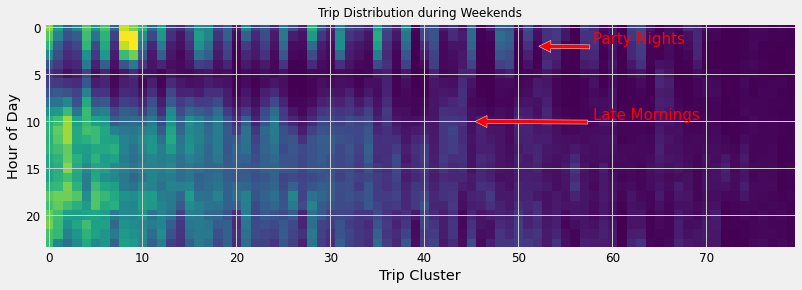

In [13]:
# calculate the trip distribution for different hours of the weekend
hoursOfDay = np.sort(taxiDB['src hourOfDay'].astype(int).unique())
clusterDistributionHourOfDay_weekend = np.zeros((len(hoursOfDay),numClusters))
for k, hour in enumerate(hoursOfDay):
    slectedInds = (taxiDB['src hourOfDay'].astype(int) == hour) & (taxiDB['dayOfWeek'] >= 5)
    currDistribution, _ = np.histogram(clusterInds[slectedInds], bins=numClusters)
    clusterDistributionHourOfDay_weekend[k,:] = currDistribution[sortedClusterInds]

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,6))
ax.set_title('Trip Distribution during Weekends', fontsize=12)
ax.imshow(clusterDistributionHourOfDay_weekend); ax.grid('off')
ax.set_xlabel('Trip Cluster'); ax.set_ylabel('Hour of Day')
ax.annotate('Party Nights', color='r', fontsize=15, xy=(52, 2), xytext=(58, 1.75),
            arrowprops=dict(facecolor='red', shrink=0.03))
ax.annotate('Late Mornings', color='r', fontsize=15, xy=(45, 10), xytext=(58, 9.75),
            arrowprops=dict(facecolor='red', shrink=0.03))

週末の間は、人々は夜間ははるかに活動的であり、通常の平日と比較すると、1日のかなり遅い時間に1日を開始していることがわかります。 赤い矢印は、グラフ上のこれら2つの時点を示します。

##### 異なる曜日の毎週の旅行分布

この「旅行のバッグ」は、1週間でどのように変化しますか？

Text(0, 0.5, 'Day of Week')

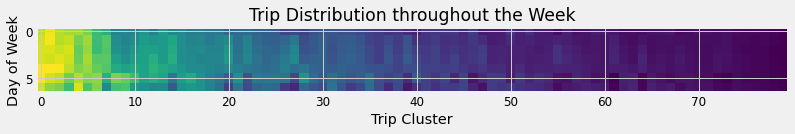

In [14]:
# calculate the trip distribution for day of week
daysOfWeek = np.sort(taxiDB['dayOfWeek'].unique())
clusterDistributionDayOfWeek = np.zeros((len(daysOfWeek),numClusters))
for k, day in enumerate(daysOfWeek):
    slectedInds = taxiDB['dayOfWeek'] == day
    currDistribution, _ = np.histogram(clusterInds[slectedInds], bins=numClusters)
    clusterDistributionDayOfWeek[k,:] = currDistribution[sortedClusterInds]

plt.figure(figsize=(12,5)); plt.title('Trip Distribution throughout the Week')
plt.imshow(clusterDistributionDayOfWeek); plt.grid('off')
plt.xlabel('Trip Cluster'); plt.ylabel('Day of Week')

ここでは、前の2つのプロットから見たものを反映しています。 週末の旅行分布のパターンは、平日とは多少異なります。

##### 年間の異なる日の年間旅行分布

この「旅行のバッグ」は、年間どのように変化しますか？

Text(50, 157, 'Memorial Day')

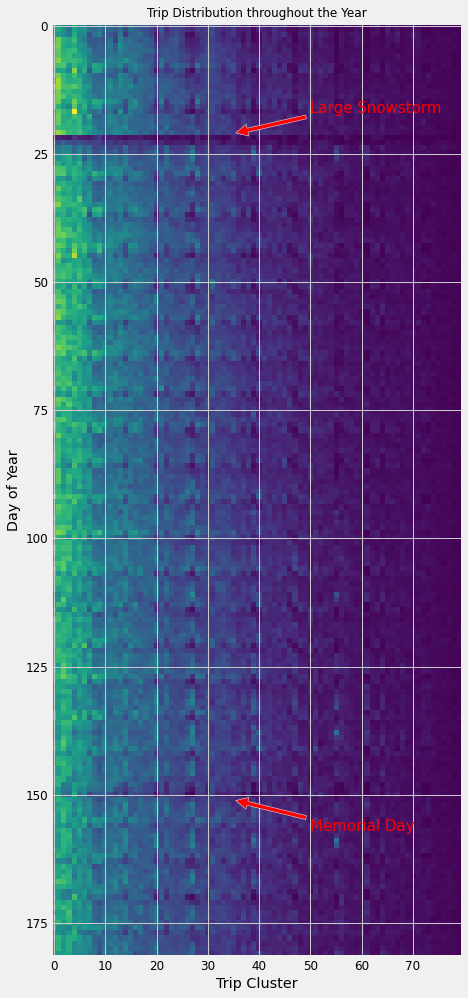

In [15]:
# calculate the trip distribution for day of year
daysOfYear = taxiDB['dayOfYear'].unique()
daysOfYear = np.sort(daysOfYear)
clusterDistributionDayOfYear = np.zeros((len(daysOfYear),numClusters))
for k, day in enumerate(daysOfYear):
    slectedInds = taxiDB['dayOfYear'] == day
    currDistribution, _ = np.histogram(clusterInds[slectedInds], bins=numClusters)
    clusterDistributionDayOfYear[k,:] = currDistribution[sortedClusterInds]

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,16))
ax.set_title('Trip Distribution throughout the Year', fontsize=12)
ax.imshow(clusterDistributionDayOfYear); ax.grid('off')
ax.set_xlabel('Trip Cluster'); ax.set_ylabel('Day of Year')
ax.annotate('Large Snowstorm', color='r', fontsize=15 ,xy=(35, 21), xytext=(50, 17),
            arrowprops=dict(facecolor='red', shrink=0.03))
ax.annotate('Memorial Day', color='r', fontsize=15, xy=(35, 151), xytext=(50, 157),
            arrowprops=dict(facecolor='red', shrink=0.03))

ここで最も明白なパターンは周期性です。 また、データには2つの大きなアクティビティの低下が見られます。1つは20〜25日目（1月末）で、もう1つは145〜150日目（5月末）です。 1月の終わりにニューヨークで大雪が降り、5月の終わりにアメリカでメモリアルデーがあることがわかりました。 これらは赤い矢印でマークされています。

##### 次に、時間的側面を詳しく見てみましょう

PCAを適用して、次元を80次元の分布ベクトルから、3次元など、より簡単にプロットして視覚化できるより扱いやすいものに減らしましょう。

In [16]:
#%% let's apply PCA to reduce the dimentionality from 80 dimentional distribution vector 
# to something more managble such as 3 dimentions

hoursOfYear = np.sort(taxiDB['hourOfYear'].astype(int).unique())
clusterDistributionHourOfYear = np.zeros((len(range(hoursOfYear[0],hoursOfYear[-1])),numClusters))
dayOfYearVec  = np.zeros(clusterDistributionHourOfYear.shape[0])
weekdayVec    = np.zeros(clusterDistributionHourOfYear.shape[0])
weekOfYearVec = np.zeros(clusterDistributionHourOfYear.shape[0])
for k, hour in enumerate(hoursOfYear):
    slectedInds = taxiDB['hourOfYear'].astype(int) == hour
    currDistribution, _ = np.histogram(clusterInds[slectedInds], bins=numClusters)
    clusterDistributionHourOfYear[k,:] = currDistribution[sortedClusterInds]
    
    dayOfYearVec[k]  = taxiDB[slectedInds]['dayOfYear'].mean()
    weekdayVec[k]    = taxiDB[slectedInds]['dayOfWeek'].mean()
    weekOfYearVec[k] = taxiDB[slectedInds]['weekOfYear'].mean()

numComponents = 3
TripDistributionPCAModel = decomposition.PCA(n_components=numComponents,whiten=True, random_state=1)
compactClusterDistributionHourOfYear = TripDistributionPCAModel.fit_transform(clusterDistributionHourOfYear)

##### 毎週の周期性

ここでは、1週間の3つの主成分係数の時間的変化を示します

(-0.9, 167.9)

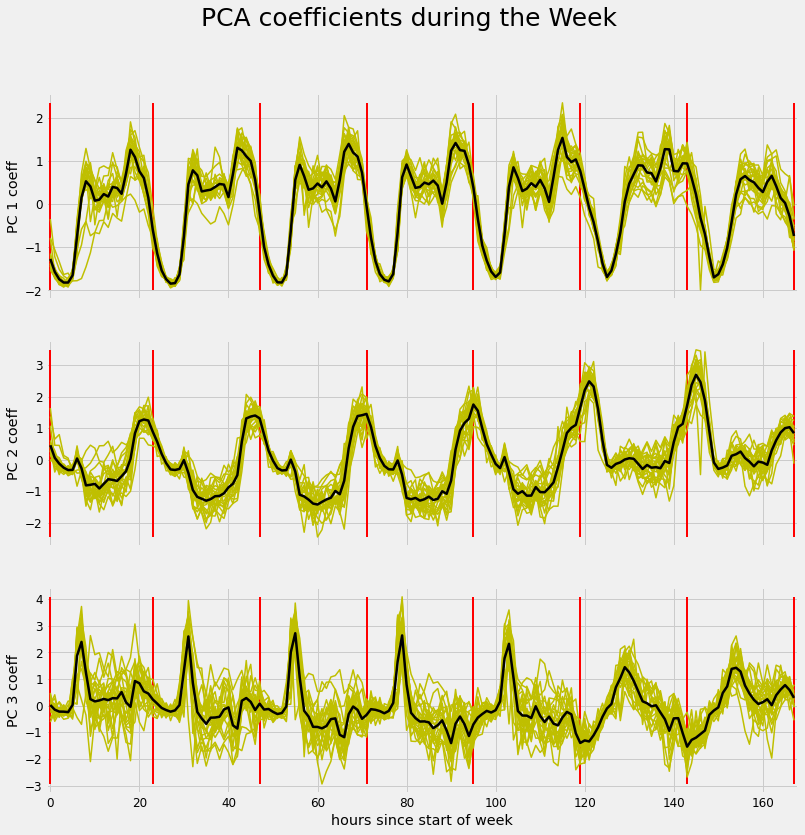

In [17]:
# collect traces for all weeks of year
listOfFullWeeks = []
for uniqueVal in np.unique(weekOfYearVec):
    if (weekOfYearVec == uniqueVal).sum() == 24*7:
        listOfFullWeeks.append(uniqueVal)

weeklyTraces = np.zeros((24*7,numComponents,len(listOfFullWeeks)))
for k, weekInd in enumerate(listOfFullWeeks):
    weeklyTraces[:,:,k] = compactClusterDistributionHourOfYear[weekOfYearVec == weekInd,:]

fig, axArray = plt.subplots(nrows=numComponents,ncols=1,sharex=True, figsize=(12,12))
fig.suptitle('PCA coefficients during the Week', fontsize=25)
for PC_coeff in range(numComponents):
    meanTrace = weeklyTraces[:,PC_coeff,:].mean(axis=1)
    axArray[PC_coeff].plot(weeklyTraces[:,PC_coeff,:],'y',linewidth=1.5)
    axArray[PC_coeff].plot(meanTrace,'k',linewidth=2.5)
    axArray[PC_coeff].set_ylabel('PC %d coeff' %(PC_coeff+1))
    axArray[PC_coeff].vlines([0,23,47,71,95,119,143,167], weeklyTraces[:,PC_coeff,:].min(), weeklyTraces[:,PC_coeff,:].max(), colors='r', lw=2)
    
axArray[PC_coeff].set_xlabel('hours since start of week')
axArray[PC_coeff].set_xlim(-0.9,24*7-0.1)

黄色は、すべての週のデータを重ね合わせたものです。 黒字は平均的なトレースです。

ここでは、周期性と、通常の平日と週末の違いを明確に見ることができます。

##### 毎日の周期性

ここでは、日中の3つの主成分係数の時間的進化を示します

Text(1, 3.5, 'Late Mornings')

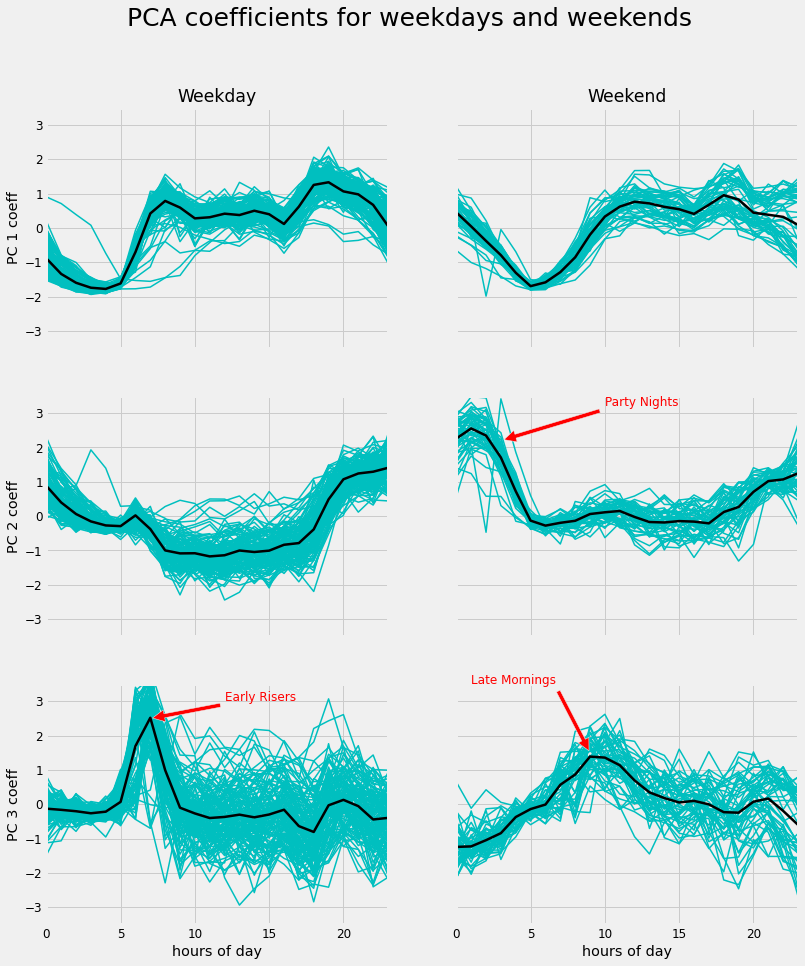

In [18]:
# collect traces for weekdays and weekends 
listOfFullWeekdays = []
listOfFullWeekends = []
for uniqueVal in np.unique(dayOfYearVec):
    if (dayOfYearVec == uniqueVal).sum() == 24:
        if weekdayVec[dayOfYearVec == uniqueVal][0] <= 4:
            listOfFullWeekdays.append(uniqueVal)
        else:
            listOfFullWeekends.append(uniqueVal)

weekdayTraces = np.zeros((24,numComponents,len(listOfFullWeekdays)))
for k, dayInd in enumerate(listOfFullWeekdays):
    weekdayTraces[:,:,k] = compactClusterDistributionHourOfYear[dayOfYearVec == dayInd,:]

weekendTraces = np.zeros((24,numComponents,len(listOfFullWeekends)))
for k, dayInd in enumerate(listOfFullWeekends):
    weekendTraces[:,:,k] = compactClusterDistributionHourOfYear[dayOfYearVec == dayInd,:]

fig, axArray = plt.subplots(nrows=numComponents,ncols=2,sharex=True,sharey=True, figsize=(12,14))
fig.suptitle('PCA coefficients for weekdays and weekends', fontsize=25)
for PC_coeff in range(numComponents):
    axArray[PC_coeff][0].plot(weekdayTraces[:,PC_coeff,:],'c',linewidth=1.5)
    axArray[PC_coeff][0].plot(weekdayTraces[:,PC_coeff,:].mean(axis=1),'k',linewidth=2.5)
    axArray[PC_coeff][0].set_ylabel('PC %d coeff' %(PC_coeff+1))
    
    axArray[PC_coeff][1].plot(weekendTraces[:,PC_coeff,:],'c',linewidth=1.5)
    axArray[PC_coeff][1].plot(weekendTraces[:,PC_coeff,:].mean(axis=1),'k',linewidth=2.5)
    
    if PC_coeff == 0:
        axArray[PC_coeff][0].set_title('Weekday')
        axArray[PC_coeff][1].set_title('Weekend')
    
axArray[PC_coeff][0].set_xlabel('hours of day')
axArray[PC_coeff][1].set_xlabel('hours of day')
axArray[PC_coeff][0].set_xlim(0,23)
axArray[PC_coeff][0].set_ylim(-3.5,3.5)

# add arrows with description
axArray[2][0].annotate('Early Risers', color='r', fontsize=12, xy=(7, 2.5), xytext=(12, 3),
            arrowprops=dict(facecolor='red', shrink=0.03))
axArray[1][1].annotate('Party Nights', color='r', fontsize=12, xy=(3, 2.2), xytext=(10, 3.2),
            arrowprops=dict(facecolor='red', shrink=0.03))
axArray[2][1].annotate('Late Mornings', color='r', fontsize=12, xy=(9, 1.5), xytext=(1, 3.5),
            arrowprops=dict(facecolor='red', shrink=0.03))

固有ベクトル（つまり、トリップ分布）を調べることにより、各PC係数が何を意味するかを正確に確認できることを思い出してください。 それをしましょう

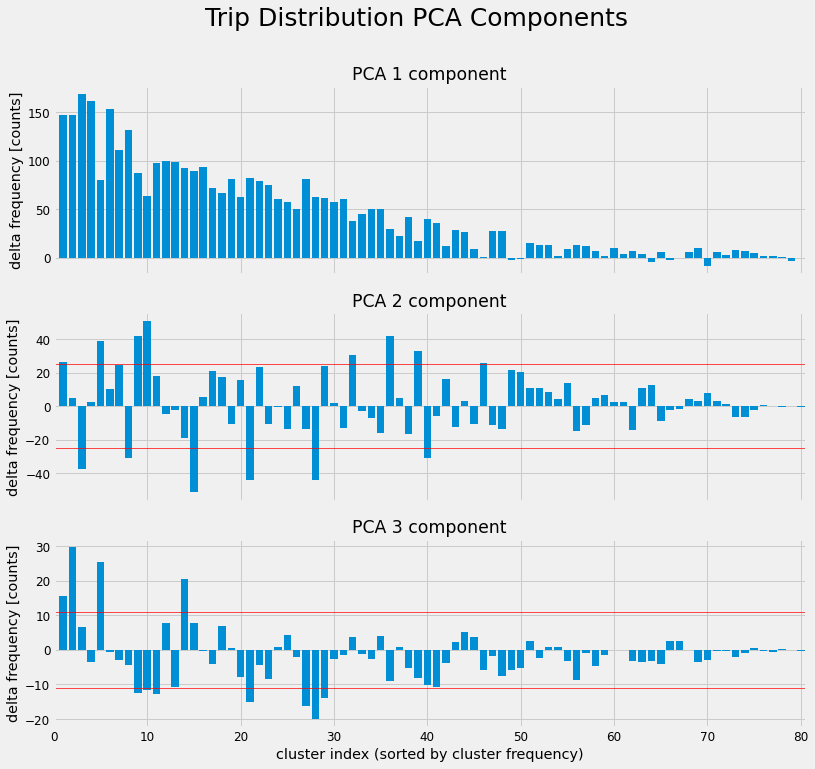

In [19]:
#%% examine what different PC coefficients mean by looking at their trip template distributions
fig, axArray = plt.subplots(nrows=numComponents,ncols=1,sharex=True, figsize=(12,11))
fig.suptitle('Trip Distribution PCA Components', fontsize=25)
for PC_coeff in range(numComponents):
    tripTemplateDistributionDifference = TripDistributionPCAModel.components_[PC_coeff,:] * \
                                         TripDistributionPCAModel.explained_variance_[PC_coeff]
    axArray[PC_coeff].bar(range(1,numClusters+1),tripTemplateDistributionDifference)
    axArray[PC_coeff].set_title('PCA %d component' %(PC_coeff+1))
    axArray[PC_coeff].set_ylabel('delta frequency [counts]')
    
axArray[PC_coeff].set_xlabel('cluster index (sorted by cluster frequency)')
axArray[PC_coeff].set_xlim(0,numClusters+0.5)

axArray[1].hlines([-25,25], 0, numClusters+0.5, colors='r', lw=0.7)
axArray[2].hlines([-11,11], 0, numClusters+0.5, colors='r', lw=0.7)

最初のPCAコンポーネントは全体的なトリップ分布に非常によく似ていることがわかります。これは、その期間の総トリップ数のみを制御する主に「ゲイン」コンポーネントであることを示唆しています。

2番目と3番目のコンポーネントには、上下に異なるパターンがあります。

それらのパターンが何であるか、特に赤い線から逸脱するすべてのものを調べてみましょう

##### PC 2 large deviating trips
赤の矢印は、PC 2係数が増加するときに増加するトリップを示します。

青色の矢印は、PC 2係数が増加するときに減少するトリップを示します。

マゼンタの円はソースで、緑の円は宛先です。

Text(0.5, 1.0, 'PC2 major Trip deviations')

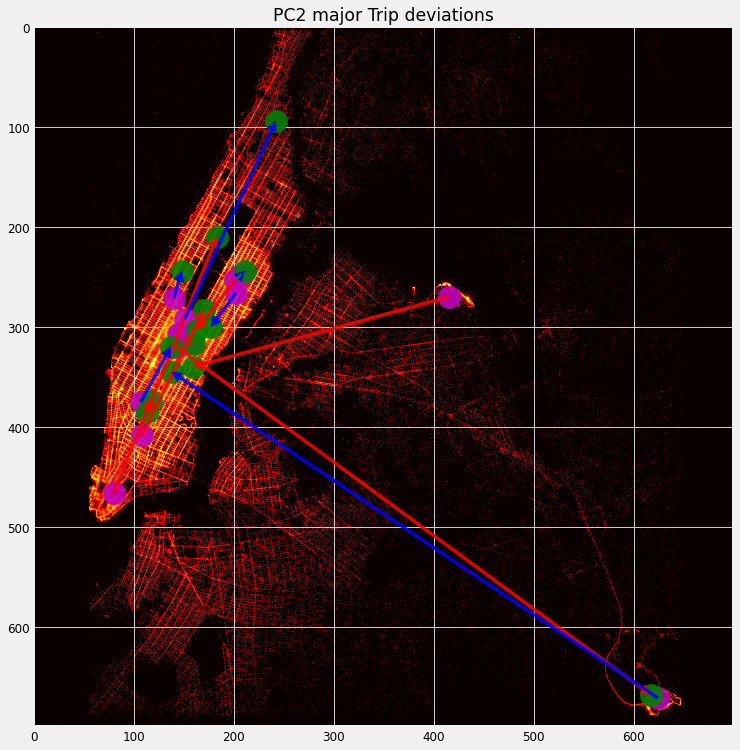

In [20]:
#%% put the large deviating trips of each component back on the map
numTopTripsToShow = 8
numBottomTripsToShow = 6

# meaning of 2nd PC
sortedTripClusters_PC2 = np.argsort(TripDistributionPCAModel.components_[1,:])
topPositiveTripClusterInds = sortedTripClusters_PC2[-numTopTripsToShow:]
topNegativeTripClusterInds = sortedTripClusters_PC2[:numBottomTripsToShow]
allInds = np.hstack((topPositiveTripClusterInds,topNegativeTripClusterInds))

plt.figure(figsize=(12,12))
plt.imshow(np.log(locationDensityImage+1),cmap='hot'); plt.grid('off')
plt.scatter(srcImCoords[1][allInds],srcImCoords[0][allInds],c='m',s=500,alpha=0.9)
plt.scatter(dstImCoords[1][allInds],dstImCoords[0][allInds],c='g',s=500,alpha=0.9)

for i in topPositiveTripClusterInds:
    plt.arrow(srcImCoords[1][i],srcImCoords[0][i], dstImCoords[1][i]-srcImCoords[1][i], dstImCoords[0][i]-srcImCoords[0][i], 
              edgecolor='r', facecolor='r', width=2.8,alpha=0.9,head_width=10.0,head_length=10.0,length_includes_head=True)

for i in topNegativeTripClusterInds:
    plt.arrow(srcImCoords[1][i],srcImCoords[0][i], dstImCoords[1][i]-srcImCoords[1][i], dstImCoords[0][i]-srcImCoords[0][i], 
              edgecolor='b', facecolor='b', width=2.8,alpha=0.9,head_width=10.0,head_length=10.0,length_includes_head=True)
plt.title('PC2 major Trip deviations')

赤の矢印は、PC係数が増加すると増加するトリップを示します。
青色の矢印は、PC係数が増加すると減少するトリップを示します。
マゼンタの円はソースで、緑の円は宛先です。

以前、PC2は夜間の活動が増加することを確認しました。 実際、私たちが目にするほとんどの旅行は、マンハッテン内の短い旅行です。おそらく人々は皆、暑い場所に行くでしょう。

##### PC 3 large deviating trips

Text(0.5, 1.0, 'PC3 major Trip deviations')

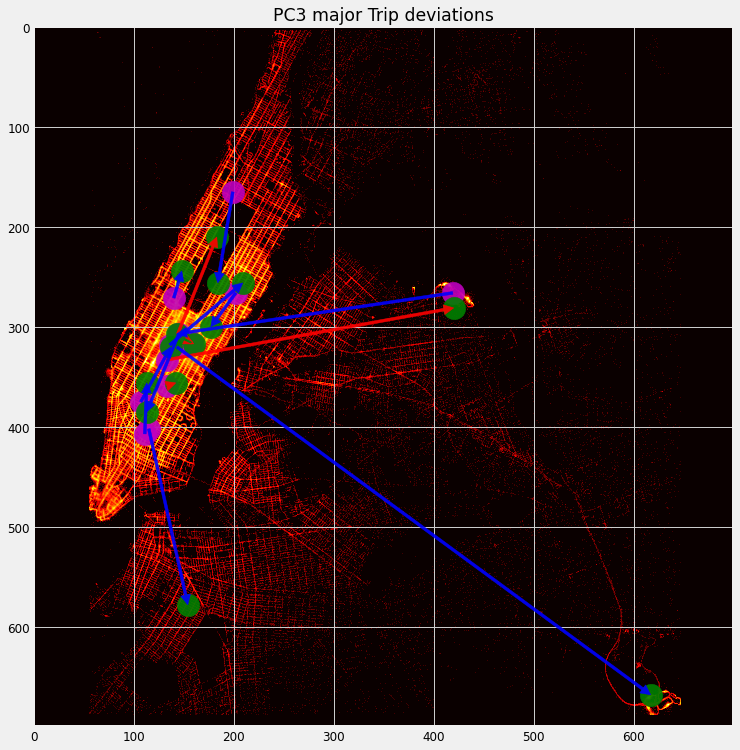

In [21]:
# meaning of 3rd PC
numTopTripsToShow = 4
numBottomTripsToShow = 10

sortedTripClusters_PC3 = np.argsort(TripDistributionPCAModel.components_[2,:])
topPositiveTripClusterInds = sortedTripClusters_PC3[-numTopTripsToShow:]
topNegativeTripClusterInds = sortedTripClusters_PC3[:numBottomTripsToShow]
allInds = np.hstack((topPositiveTripClusterInds,topNegativeTripClusterInds))

plt.figure(figsize=(12,12))
plt.imshow(np.log(locationDensityImage+1),cmap='hot'); plt.grid('off')
plt.scatter(srcImCoords[1][allInds],srcImCoords[0][allInds],c='m',s=500,alpha=0.9)
plt.scatter(dstImCoords[1][allInds],dstImCoords[0][allInds],c='g',s=500,alpha=0.9)

for i in topPositiveTripClusterInds:
    plt.arrow(srcImCoords[1][i],srcImCoords[0][i], dstImCoords[1][i]-srcImCoords[1][i], dstImCoords[0][i]-srcImCoords[0][i], 
              edgecolor='r', facecolor='r', width=2.8,alpha=0.9,head_width=10.0,head_length=10.0,length_includes_head=True)

for i in topNegativeTripClusterInds:
    plt.arrow(srcImCoords[1][i],srcImCoords[0][i], dstImCoords[1][i]-srcImCoords[1][i], dstImCoords[0][i]-srcImCoords[0][i], 
              edgecolor='b', facecolor='b', width=2.8,alpha=0.9,head_width=10.0,head_length=10.0,length_includes_head=True)
plt.title('PC3 major Trip deviations')

これは、これが早起きでどの旅行が行われるかを示す主要なコンポーネントであることを以前に確認しました。

以上が、ノートブックの内容。

### 課題
- 他のノートブックにも興味深い分析方法があったので、参照してみる。
- 上記の分析をもとに特徴量選択し、学習・予測してみる。
  - 特徴量として生カラム・PCA次元削減をしたものそれぞれの結果を比較
  - PCAの要素数を増やして分析してみる

### 上記の分析をもとに特徴量選択し、学習・予測してみる。
#### 特徴量として生カラム・PCA次元削減をしたものそれぞれの結果を比較

※PCA次元削減したものでは結果を出さなかった。理由は、次元削減する前にある軸でクラスタリングをしており、目的変数をデータ数分読み込める形になっていなかったため(平均値を設定するという手はあったかもしれないが、今回はなし)。PCAの要素数を増やして分析もスキップ。

In [23]:
taxiDB

id  vendor_id      pickup_datetime     dropoff_datetime  \
0        id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1        id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2        id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3        id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4        id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   
...            ...        ...                  ...                  ...   
1420053  id2376096          2  2016-04-08 13:31:04  2016-04-08 13:44:02   
1420054  id1049543          1  2016-01-10 07:35:15  2016-01-10 07:46:10   
1420055  id2304944          2  2016-04-22 06:57:41  2016-04-22 07:10:25   
1420056  id2714485          1  2016-01-05 15:56:26  2016-01-05 16:02:39   
1420057  id1209952          1  2016-04-05 14:44:25  2016-04-05 14:47:43   

         passenger_count  pickup_longitude  pickup_latitude  \
0                      1        -73.982155        40.767937   
1                      1        -73.980415        40.738564   
2                      1        -73.979027        40.763939   
3                      1        -74.010040        40.719971   
4                      1        -73.973053        40.793209   
...                  ...               ...              ...   
1420053                4        -73.982201        40.745522   
1420054                1        -74.000946        40.747379   
1420055                1        -73.959129        40.768799   
1420056                1        -73.982079        40.749062   
1420057                1        -73.979538        40.781750   

         dropoff_longitude  dropoff_latitude store_and_fwd_flag  ...  \
0               -73.964630         40.765602                  N  ...   
1               -73.999481         40.731152                  N  ...   
2               -74.005333         40.710087                  N  ...   
3               -74.012268         40.706718                  N  ...   
4               -73.972923         40.782520                  N  ...   
...                    ...               ...                ...  ...   
1420053         -73.994911         40.740170                  N  ...   
1420054         -73.970184         40.796547                  N  ...   
1420055         -74.004433         40.707371                  N  ...   
1420056         -73.974632         40.757107                  N  ...   
1420057         -73.972809         40.790585                  N  ...   

         log duration  euclidian distance  src hourOfDay  dst hourOfDay  \
0            2.149822            1.500473      17.400000      17.526389   
1            2.489065            1.807114       0.716667       0.900833   
2            3.594569            6.392077      11.583333      12.173333   
3            2.098018            1.487155      19.533333      19.652500   
4            2.110213            1.189925      13.500000      13.620833   
...               ...                 ...            ...            ...   
1420053      2.636674            1.226293      13.516667      13.732778   
1420054      2.477938            6.056931       7.583333       7.765278   
1420055      2.619826            7.832945       6.950000       7.162222   
1420056      1.976393            1.093785      15.933333      16.036944   
1420057      1.458615            1.135452      14.733333      14.788333   

         dayOfWeek  hourOfWeek  monthOfYear  dayOfYear  weekOfYear  \
0                0   17.400000            3         74          11   
1                6  144.716667            6        164          23   
2                1   35.583333            1         19           3   
3                2   67.533333            4         97          14   
4                5  133.500000            3         86          12   
...            ...         ...          ...        ...         ...   
1420053          4  109.516667            4         99          14   
1420054          6  151.583333  

In [218]:
list_drop = ["dropoff_datetime", "pickup_datetime", "pickup_latitude", "pickup_longitude", "dropoff_latitude",
             "dropoff_longitude", "trip_duration", "store_and_fwd_flag", "log duration", "id", "duration [min]", "dst hourOfDay"]
taxiDB_train = taxiDB.drop(columns=list_drop)
taxiDB_train

vendor_id  passenger_count  src lat [km]  src long [km]  \
0                2                1      1.486707      -0.099721   
1                1                1     -1.783114       0.046965   
2                2                1      1.041672       0.164056   
3                2                1     -3.852868      -2.451197   
4                2                1      4.300027       0.667806   
...            ...              ...           ...            ...   
1420053          2                4     -1.008549      -0.103581   
1420054          1                1     -0.801743      -1.684313   
1420055          2                1      1.582678       1.841936   
1420056          1                1     -0.614472      -0.093287   
1420057          1                1      3.024372       0.120951   

         dst lat [km]  dst long [km]  euclidian distance  src hourOfDay  \
0            1.226820       1.378075            1.500473      17.400000   
1           -2.608213      -1.560788            1.807114       0.716667   
2           -4.953142      -2.054245            6.392077      11.583333   
3           -5.328110      -2.639058            1.487155      19.533333   
4            3.110152       0.678744            1.189925      13.500000   
...               ...            ...                 ...            ...   
1420053     -1.604336      -1.175417            1.226293      13.516667   
1420054      4.671598       0.909709            6.056931       7.583333   
1420055     -5.255494      -1.978328            7.832945       6.950000   
1420056      0.281120       0.534631            1.093785      15.933333   
1420057      4.007867       0.688394            1.135452      14.733333   

         dayOfWeek  hourOfWeek  monthOfYear  dayOfYear  weekOfYear  \
0                0   17.400000            3         74          11   
1                6  144.716667            6        164          23   
2                1   35.583333            1         19           3   
3                2   67.533333            4         97          14   
4                5  133.500000            3         86          12   
...            ...         ...          ...        ...         ...   
1420053          4  109.516667            4         99          14   
1420054          6  151.583333            1         10           1   
1420055          4  102.950000            4        113          16   
1420056          1   39.933333            1          5           1   
1420057          1   38.733333            4         96          14   

          hourOfYear  
0        1793.400000  
1        3936.716667  
2         467.583333  
3        2347.533333  
4        2077.500000  
...              ...  
1420053  2389.516667  
1420054   247.583333  
1420055  2718.950000  
1420056   135.933333  
1420057  2318.733333  

[1420058 rows x 14 columns]

In [126]:
from sklearn.model_selection import train_test_split

X = taxiDB_train
y = taxiDB['trip_duration']
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=32)

(1420058, 14) (1420058,)


In [127]:
from sklearn.model_selection import GridSearchCV
import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_log_error
from catboost import Pool

モデルはCatBoostを選択。理由は以下。
- 特に手を加えずとも学習過程(残り時間など)が見える。
- 速い。

今回のコンペの評価指標であるRMSLEをCatBoostの損失関数が対応していないため、公式ドキュメントに従ってクラスを自作。

$$
RMSLE(Root Mean Squared Logarithmic Error) = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2}
$$

[(公式ドキュメントの該当ページ)](https://catboost.ai/docs/concepts/python-usages-examples.html#user-defined-loss-function)
```
To set a user-defined loss function, create an object that implements the following interface:

class UserDefinedObjective(object):
    def calc_ders_range(self, approxes, targets, weights):
        # approxes, targets, weights are indexed containers of floats
        # (containers which have only __len__ and __getitem__ defined).
        # weights parameter can be None.
        #
        # To understand what these parameters mean, assume that there is
        # a subset of your dataset that is currently being processed.
        # approxes contains current predictions for this subset,
        # targets contains target values you provided with the dataset.
        #
        # This function should return a list of pairs (der1, der2), where
        # der1 is the first derivative of the loss function with respect
        # to the predicted value, and der2 is the second derivative.
        pass
        
class UserDefinedMetric(object):
    def is_max_optimal(self):
        # Returns whether great values of metric are better
        pass

    def evaluate(self, approxes, target, weight):
        # approxes is a list of indexed containers
        # (containers with only __len__ and __getitem__ defined),
        # one container per approx dimension.
        # Each container contains floats.
        # weight is a one dimensional indexed container.
        # target is a one dimensional indexed container.
        
        # weight parameter can be None.
        # Returns pair (error, weights sum)
        pass
    
    def get_final_error(self, error, weight):
        # Returns final value of metric based on error and weight
        pass
```

##### 補足
- 定義した関数が正しいかどうかは分からない。
- 動くようにはなったが、自作評価関数だと処理時間がかなり延びる。今回はグリッドサーチは諦める。
- 学習モデルの損失関数はRMSLEにせず、oputunaによるtrialの返り値をRMSLEにしたもので試したが、predictでエラーになった(予測値が負の値になって指標値が計算できなかった)。
- 自作評価関数にした途端GPUが使えなくなった(エラーになった)。catboostでもともと持っている損失関数の処理はCython(pythonをC言語ライクにコンパイルするためのファイル)で実装されている処理内でcuda環境(GPUのAPIを呼び出すための環境)に触っていると思われる。リソースにアタッチする処理を実装しGPU環境を使えるようにすることは私の仕事ではない。解散。

In [128]:
class RMSLE_loss(object):
    def calc_ders_range(self, approxes, targets, weights):
        assert len(approxes) == len(targets)
        if weights is not None:
            assert len(weights) == len(approxes)

        result = []
        for index in range(len(targets)):
            der1 = (np.log(targets[index]+1) - np.log(approxes[index]+1)) / (approxes[index]+1)
            der2 = -(np.log(targets[index]+1) + np.log(approxes[index]+1) + 1) / ((approxes[index]+1)**2)

            if weights is not None:
                der1 *= weights[index]
                der2 *= weights[index]

            result.append((der1, der2))
        return result

class RMSLE_metric(object):
    def get_final_error(self, error, weight):
        return np.sqrt(error / (weight + 1e-38))

    def is_max_optimal(self):
        return False

    def evaluate(self, approxes, target, weight):
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        approx = approxes[0]

        error_sum = 0.0
        weight_sum = 0.0

        for i in range(len(approx)):
            w = 1.0 if weight is None else weight[i]
            weight_sum += w
            error_sum += w * ((np.log(target[i]+1)-np.log(approx[i]+1))**2)

        return error_sum, weight_sum

In [130]:
train_pool = Pool(X_train, y_train)
validate_pool = Pool(X_test, y_test)

cb = CatBoostRegressor(learning_rate=1, depth=10, loss_function=RMSLE_loss(), eval_metric=RMSLE_metric(), iterations=300)
cb = cb.fit(train_pool, eval_set=validate_pool, early_stopping_rounds=10, use_best_model=True)

0:	learn: 5.8755885	test: 5.8734564	best: 5.8734564 (0)	total: 16.8s	remaining: 1h 23m 41s
1:	learn: 5.3365131	test: 5.3344190	best: 5.3344190 (1)	total: 34.1s	remaining: 1h 24m 33s
2:	learn: 4.8625297	test: 4.8604711	best: 4.8604711 (2)	total: 51.4s	remaining: 1h 24m 46s
3:	learn: 4.4425661	test: 4.4405791	best: 4.4405791 (3)	total: 1m 8s	remaining: 1h 24m 35s
4:	learn: 4.0696625	test: 4.0677075	best: 4.0677075 (4)	total: 1m 26s	remaining: 1h 24m 53s
5:	learn: 3.7363506	test: 3.7344501	best: 3.7344501 (5)	total: 1m 43s	remaining: 1h 24m 45s
6:	learn: 3.4387205	test: 3.4368723	best: 3.4368723 (6)	total: 2m	remaining: 1h 24m 12s
7:	learn: 3.1683104	test: 3.1665067	best: 3.1665067 (7)	total: 2m 17s	remaining: 1h 23m 51s
8:	learn: 2.9263485	test: 2.9245253	best: 2.9245253 (8)	total: 2m 34s	remaining: 1h 23m 28s
9:	learn: 2.7103692	test: 2.7086041	best: 2.7086041 (9)	total: 2m 51s	remaining: 1h 23m 4s
10:	learn: 2.5230948	test: 2.5213373	best: 2.5213373 (10)	total: 3m 8s	remaining: 1h 22m 

88:	learn: 0.6375058	test: 0.6381167	best: 0.6381167 (88)	total: 25m 19s	remaining: 1h 1s
89:	learn: 0.6355577	test: 0.6361705	best: 0.6361705 (89)	total: 25m 36s	remaining: 59m 45s
90:	learn: 0.6331038	test: 0.6337335	best: 0.6337335 (90)	total: 25m 53s	remaining: 59m 28s
91:	learn: 0.6313023	test: 0.6319330	best: 0.6319330 (91)	total: 26m 10s	remaining: 59m 10s
92:	learn: 0.6295601	test: 0.6301909	best: 0.6301909 (92)	total: 26m 27s	remaining: 58m 53s
93:	learn: 0.6276622	test: 0.6283010	best: 0.6283010 (93)	total: 26m 44s	remaining: 58m 36s
94:	learn: 0.6255753	test: 0.6262244	best: 0.6262244 (94)	total: 27m 1s	remaining: 58m 19s
95:	learn: 0.6238227	test: 0.6244762	best: 0.6244762 (95)	total: 27m 18s	remaining: 58m 2s
96:	learn: 0.6222015	test: 0.6228554	best: 0.6228554 (96)	total: 27m 36s	remaining: 57m 45s
97:	learn: 0.6206097	test: 0.6212640	best: 0.6212640 (97)	total: 27m 52s	remaining: 57m 28s
98:	learn: 0.6186316	test: 0.6192974	best: 0.6192974 (98)	total: 28m 10s	remaining: 

176:	learn: 0.5330331	test: 0.5338763	best: 0.5338763 (176)	total: 50m 19s	remaining: 34m 58s
177:	learn: 0.5322738	test: 0.5331167	best: 0.5331167 (177)	total: 50m 36s	remaining: 34m 41s
178:	learn: 0.5315138	test: 0.5323569	best: 0.5323569 (178)	total: 50m 53s	remaining: 34m 24s
179:	learn: 0.5307641	test: 0.5316075	best: 0.5316075 (179)	total: 51m 11s	remaining: 34m 7s
180:	learn: 0.5303154	test: 0.5311579	best: 0.5311579 (180)	total: 51m 28s	remaining: 33m 50s
181:	learn: 0.5295869	test: 0.5304300	best: 0.5304300 (181)	total: 51m 45s	remaining: 33m 33s
182:	learn: 0.5289352	test: 0.5297801	best: 0.5297801 (182)	total: 52m 2s	remaining: 33m 16s
183:	learn: 0.5282245	test: 0.5290695	best: 0.5290695 (183)	total: 52m 19s	remaining: 32m 59s
184:	learn: 0.5275937	test: 0.5284408	best: 0.5284408 (184)	total: 52m 36s	remaining: 32m 42s
185:	learn: 0.5269037	test: 0.5277507	best: 0.5277507 (185)	total: 52m 53s	remaining: 32m 25s
186:	learn: 0.5261770	test: 0.5270260	best: 0.5270260 (186)	to

263:	learn: 0.4918451	test: 0.4926661	best: 0.4926661 (263)	total: 1h 15m 10s	remaining: 10m 15s
264:	learn: 0.4915303	test: 0.4923502	best: 0.4923502 (264)	total: 1h 15m 27s	remaining: 9m 57s
265:	learn: 0.4912203	test: 0.4920389	best: 0.4920389 (265)	total: 1h 15m 44s	remaining: 9m 40s
266:	learn: 0.4909122	test: 0.4917301	best: 0.4917301 (266)	total: 1h 16m 1s	remaining: 9m 23s
267:	learn: 0.4906067	test: 0.4914240	best: 0.4914240 (267)	total: 1h 16m 18s	remaining: 9m 6s
268:	learn: 0.4903052	test: 0.4911214	best: 0.4911214 (268)	total: 1h 16m 35s	remaining: 8m 49s
269:	learn: 0.4900062	test: 0.4908216	best: 0.4908216 (269)	total: 1h 16m 52s	remaining: 8m 32s
270:	learn: 0.4897103	test: 0.4905246	best: 0.4905246 (270)	total: 1h 17m 9s	remaining: 8m 15s
271:	learn: 0.4894085	test: 0.4902225	best: 0.4902225 (271)	total: 1h 17m 26s	remaining: 7m 58s
272:	learn: 0.4891145	test: 0.4899275	best: 0.4899275 (272)	total: 1h 17m 43s	remaining: 7m 41s
273:	learn: 0.4888315	test: 0.4896429	best

In [131]:
y_pred = cb.predict(X_test)
mean_squared_log_error(y_test, y_pred)

0.2330514899283802

小さすぎる…おかしい。間違えているとしたら自作関数。テストデータで検証してるので過学習ということは無いと考えている。自作関数の間違いがわからないが、とりあえず提出してみる。

In [135]:
testDB = pd.read_csv('test.csv')

# remove obvious outliers
allLat  = np.array(list(testDB['pickup_latitude'])  + list(testDB['dropoff_latitude']))
allLong = np.array(list(testDB['pickup_longitude']) + list(testDB['dropoff_longitude']))

# convert fields to sensible units
medianLat  = np.percentile(allLat,50)
medianLong = np.percentile(allLong,50)

latMultiplier  = 111.32 # 緯度1度あたりの距離(km)
longMultiplier = np.cos(medianLat*(np.pi/180.0)) * 111.32 # 経度1度あたりの距離(km)

testDB['src lat [km]']   = latMultiplier  * (testDB['pickup_latitude']   - medianLat)
testDB['src long [km]']  = longMultiplier * (testDB['pickup_longitude']  - medianLong)
testDB['dst lat [km]']   = latMultiplier  * (testDB['dropoff_latitude']  - medianLat)
testDB['dst long [km]']  = longMultiplier * (testDB['dropoff_longitude'] - medianLong)

allLat  = np.array(list(testDB['src lat [km]'])  + list(testDB['dst lat [km]']))
allLong = np.array(list(testDB['src long [km]']) + list(testDB['dst long [km]']))

testDB['euclidian distance'] = np.sqrt((testDB['src lat [km]']  - testDB['dst lat [km]'] )**2 + 
                                       (testDB['src long [km]'] - testDB['dst long [km]'])**2)

pickupTime = pd.to_datetime(testDB['pickup_datetime'])
testDB['src hourOfDay'] = (pickupTime.dt.hour*60.0 + pickupTime.dt.minute)   / 60.0
# testDB['dst hourOfDay'] = (dropoffTime.dt.hour*60.0 + dropoffTime.dt.minute) / 60.0

testDB['dayOfWeek']     = pickupTime.dt.weekday
testDB['hourOfWeek']    = testDB['dayOfWeek']*24.0 + testDB['src hourOfDay']

testDB['monthOfYear']   = pickupTime.dt.month
testDB['dayOfYear']     = pickupTime.dt.dayofyear
testDB['weekOfYear']    = pickupTime.dt.weekofyear
testDB['hourOfYear']    = testDB['dayOfYear']*24.0 + testDB['src hourOfDay']


list_drop = ["pickup_datetime", "pickup_latitude", "pickup_longitude", "dropoff_latitude",
             "dropoff_longitude", "store_and_fwd_flag", "id"]
testDB_drop = testDB.drop(columns=list_drop)

sub_pred = cb.predict(testDB_drop)

submission = pd.DataFrame()
submission['id'] = testDB.id.values
submission['trip_duration'] = sub_pred
submission.to_csv('submission.csv', index=False)

- Private Score:0.56566
- Public Score:0.56607

順位は付かないが、当時のプライベートスコアで892/1254くらいの位置。

max_depth=5で検証するとどうなるか気になったので、試してみる。

In [136]:
cb_2 = CatBoostRegressor(learning_rate=1, depth=5, loss_function=RMSLE_loss(), eval_metric=RMSLE_metric(), iterations=300)
cb_2 = cb_2.fit(train_pool, eval_set=validate_pool, early_stopping_rounds=10, use_best_model=True)
y_pred_2 = cb_2.predict(X_test)
mean_squared_log_error(y_test, y_pred_2)

0:	learn: 5.8755658	test: 5.8734368	best: 5.8734368 (0)	total: 16.7s	remaining: 1h 23m 13s
1:	learn: 5.3364778	test: 5.3343812	best: 5.3343812 (1)	total: 34.2s	remaining: 1h 25m
2:	learn: 4.8625115	test: 4.8604139	best: 4.8604139 (2)	total: 51.6s	remaining: 1h 25m 10s
3:	learn: 4.4426677	test: 4.4406200	best: 4.4406200 (3)	total: 1m 9s	remaining: 1h 25m 12s
4:	learn: 4.0688382	test: 4.0667968	best: 4.0667968 (4)	total: 1m 26s	remaining: 1h 25m 32s
5:	learn: 3.7341313	test: 3.7321564	best: 3.7321564 (5)	total: 1m 44s	remaining: 1h 25m 21s
6:	learn: 3.4334915	test: 3.4315880	best: 3.4315880 (6)	total: 2m 1s	remaining: 1h 24m 56s
7:	learn: 3.1625652	test: 3.1606981	best: 3.1606981 (7)	total: 2m 18s	remaining: 1h 24m 31s
8:	learn: 2.9175509	test: 2.9157108	best: 2.9157108 (8)	total: 2m 35s	remaining: 1h 23m 55s
9:	learn: 2.6970692	test: 2.6953069	best: 2.6953069 (9)	total: 2m 53s	remaining: 1h 23m 39s
10:	learn: 2.4958048	test: 2.4941003	best: 2.4941003 (10)	total: 3m 10s	remaining: 1h 23m

88:	learn: 0.4430154	test: 0.4426809	best: 0.4426809 (88)	total: 25m 19s	remaining: 1h 2s
89:	learn: 0.4421115	test: 0.4417798	best: 0.4417798 (89)	total: 25m 36s	remaining: 59m 44s
90:	learn: 0.4415281	test: 0.4412022	best: 0.4412022 (90)	total: 25m 53s	remaining: 59m 26s
91:	learn: 0.4409362	test: 0.4406134	best: 0.4406134 (91)	total: 26m 9s	remaining: 59m 9s
92:	learn: 0.4404687	test: 0.4401409	best: 0.4401409 (92)	total: 26m 26s	remaining: 58m 51s
93:	learn: 0.4398942	test: 0.4395657	best: 0.4395657 (93)	total: 26m 43s	remaining: 58m 34s
94:	learn: 0.4389882	test: 0.4386550	best: 0.4386550 (94)	total: 27m 1s	remaining: 58m 19s
95:	learn: 0.4383178	test: 0.4379870	best: 0.4379870 (95)	total: 27m 18s	remaining: 58m 1s
96:	learn: 0.4374751	test: 0.4371504	best: 0.4371504 (96)	total: 27m 35s	remaining: 57m 44s
97:	learn: 0.4368275	test: 0.4365063	best: 0.4365063 (97)	total: 27m 53s	remaining: 57m 28s
98:	learn: 0.4363273	test: 0.4360020	best: 0.4360020 (98)	total: 28m 10s	remaining: 57

176:	learn: 0.4146569	test: 0.4144042	best: 0.4144042 (176)	total: 50m 15s	remaining: 34m 55s
177:	learn: 0.4144738	test: 0.4142216	best: 0.4142216 (177)	total: 50m 32s	remaining: 34m 38s
178:	learn: 0.4144054	test: 0.4141527	best: 0.4141527 (178)	total: 50m 49s	remaining: 34m 21s
179:	learn: 0.4143029	test: 0.4140489	best: 0.4140489 (179)	total: 51m 6s	remaining: 34m 4s
180:	learn: 0.4141491	test: 0.4139010	best: 0.4139010 (180)	total: 51m 23s	remaining: 33m 47s
181:	learn: 0.4140838	test: 0.4138349	best: 0.4138349 (181)	total: 51m 40s	remaining: 33m 30s
182:	learn: 0.4138956	test: 0.4136454	best: 0.4136454 (182)	total: 51m 57s	remaining: 33m 12s
183:	learn: 0.4138047	test: 0.4135537	best: 0.4135537 (183)	total: 52m 14s	remaining: 32m 56s
184:	learn: 0.4135278	test: 0.4132837	best: 0.4132837 (184)	total: 52m 32s	remaining: 32m 39s
185:	learn: 0.4133648	test: 0.4131224	best: 0.4131224 (185)	total: 52m 49s	remaining: 32m 22s
186:	learn: 0.4133270	test: 0.4130842	best: 0.4130842 (186)	to

263:	learn: 0.4064224	test: 0.4062422	best: 0.4062422 (263)	total: 1h 14m 43s	remaining: 10m 11s
264:	learn: 0.4062548	test: 0.4060849	best: 0.4060849 (264)	total: 1h 15m 1s	remaining: 9m 54s
265:	learn: 0.4061762	test: 0.4060088	best: 0.4060088 (265)	total: 1h 15m 18s	remaining: 9m 37s
266:	learn: 0.4060989	test: 0.4059334	best: 0.4059334 (266)	total: 1h 15m 36s	remaining: 9m 20s
267:	learn: 0.4060552	test: 0.4058889	best: 0.4058889 (267)	total: 1h 15m 53s	remaining: 9m 3s
268:	learn: 0.4060270	test: 0.4058610	best: 0.4058610 (268)	total: 1h 16m 11s	remaining: 8m 46s
269:	learn: 0.4059444	test: 0.4057784	best: 0.4057784 (269)	total: 1h 16m 29s	remaining: 8m 29s
270:	learn: 0.4058765	test: 0.4057093	best: 0.4057093 (270)	total: 1h 16m 46s	remaining: 8m 12s
271:	learn: 0.4058528	test: 0.4056863	best: 0.4056863 (271)	total: 1h 17m 4s	remaining: 7m 56s
272:	learn: 0.4058175	test: 0.4056521	best: 0.4056521 (272)	total: 1h 17m 21s	remaining: 7m 39s
273:	learn: 0.4057789	test: 0.4056129	best

0.1629108550513325

In [138]:
sub_pred = cb_2.predict(testDB_drop)

submission = pd.DataFrame()
submission['id'] = testDB.id.values
submission['trip_duration'] = sub_pred
submission.to_csv('submission_2.csv', index=False)

- Private Score:0.49135
- Public Score:0.49180

大分改善した。

プライベートスコア順位(当時)：772/1254

#### クラスタリング→PCAによる次元削減
[PCAのイメージ](https://nbviewer.jupyter.org/github/contaconta/PCA_lecture/blob/master/PCA.ipynb)


(0.0, 81.0)

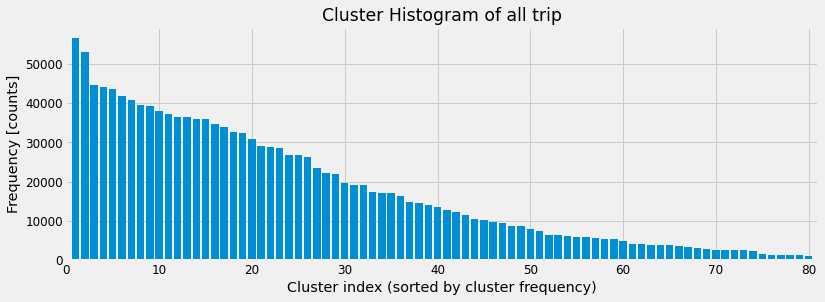

In [139]:
# PCAによる削減
tripAttributes = np.array(taxiDB.loc[:,['src lat [km]','src long [km]','dst lat [km]','dst long [km]']])
meanTripAttr = tripAttributes.mean(axis=0)
stdTripAttr  = tripAttributes.std(axis=0)
tripAttributes = stats.zscore(tripAttributes, axis=0)

numClusters = 80
TripKmeansModel = cluster.MiniBatchKMeans(n_clusters=numClusters, batch_size=120000, n_init=100, random_state=1)
clusterInds = TripKmeansModel.fit_predict(tripAttributes)

clusterTotalCounts, _ = np.histogram(clusterInds, bins=numClusters)
sortedClusterInds = np.flipud(np.argsort(clusterTotalCounts))

plt.figure(figsize=(12,4)); plt.title('Cluster Histogram of all trip')
plt.bar(range(1,numClusters+1),clusterTotalCounts[sortedClusterInds])
plt.ylabel('Frequency [counts]'); plt.xlabel('Cluster index (sorted by cluster frequency)')
plt.xlim(0,numClusters+1)

In [140]:
hoursOfYear = np.sort(taxiDB['hourOfYear'].astype(int).unique())
clusterDistributionHourOfYear = np.zeros((len(range(hoursOfYear[0],hoursOfYear[-1])),numClusters))
dayOfYearVec  = np.zeros(clusterDistributionHourOfYear.shape[0])
weekdayVec    = np.zeros(clusterDistributionHourOfYear.shape[0])
weekOfYearVec = np.zeros(clusterDistributionHourOfYear.shape[0])
for k, hour in enumerate(hoursOfYear):
    slectedInds = taxiDB['hourOfYear'].astype(int) == hour
    currDistribution, _ = np.histogram(clusterInds[slectedInds], bins=numClusters)
    clusterDistributionHourOfYear[k,:] = currDistribution[sortedClusterInds]
    
    dayOfYearVec[k]  = taxiDB[slectedInds]['dayOfYear'].mean()
    weekdayVec[k]    = taxiDB[slectedInds]['dayOfWeek'].mean()
    weekOfYearVec[k] = taxiDB[slectedInds]['weekOfYear'].mean()

numComponents = 3
TripDistributionPCAModel = decomposition.PCA(n_components=numComponents,whiten=True, random_state=1)
compactClusterDistributionHourOfYear = TripDistributionPCAModel.fit_transform(clusterDistributionHourOfYear)

(0.0, 80.5)

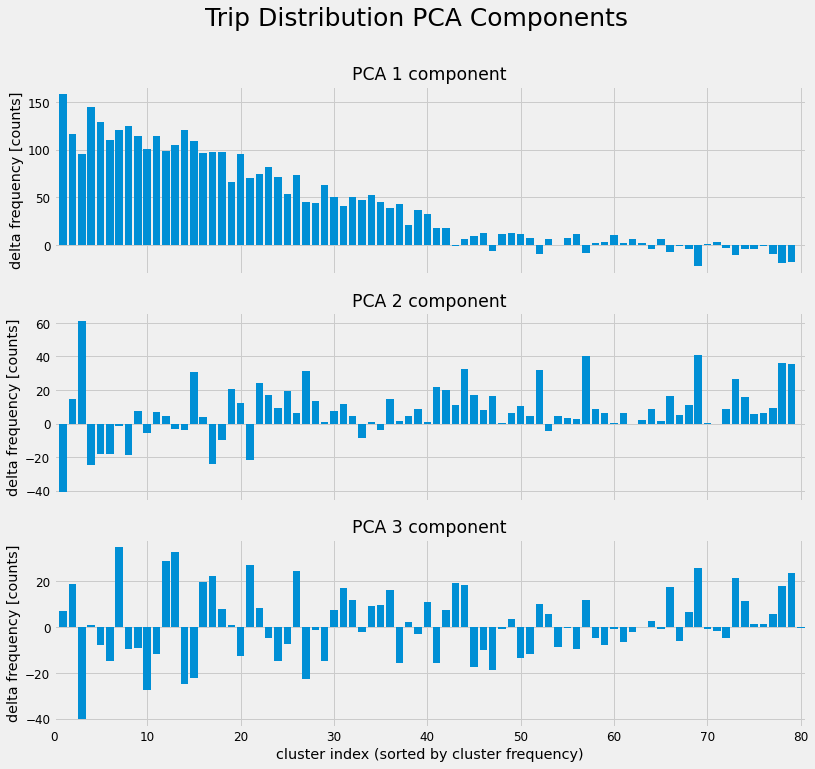

In [151]:
fig, axArray = plt.subplots(nrows=numComponents,ncols=1,sharex=True, figsize=(12,11))
fig.suptitle('Trip Distribution PCA Components', fontsize=25)
for PC_coeff in range(numComponents):
    tripTemplateDistributionDifference = TripDistributionPCAModel.components_[PC_coeff,:] * \
                                         TripDistributionPCAModel.explained_variance_[PC_coeff]
    axArray[PC_coeff].bar(range(1,numClusters+1),tripTemplateDistributionDifference)
    axArray[PC_coeff].set_title('PCA %d component' %(PC_coeff+1))
    axArray[PC_coeff].set_ylabel('delta frequency [counts]')
    
axArray[PC_coeff].set_xlabel('cluster index (sorted by cluster frequency)')
axArray[PC_coeff].set_xlim(0,numClusters+0.5)

今回の場合、やっていることは以下のイメージ
1. 4つのカラム('src lat [km]','src long [km]','dst lat [km]','dst long [km]')をもとに80のクラスタに分類
2. "hourOfYear"(ピックアップしたときの絶対的な時間)の種類数をサンプル数とした、各クラスターの分布数データを作成
  - 分布数データの各サンプルについて、"dayOfYear(年の順番の日(今回のデータは0〜182))","dayOfWeek(月曜日= 0、日曜日= 6の曜日)","weekOfYear(年の順番の週(今回のデータは0〜26))"の平均値を格納したベクトルを作成
  - ピックアップしたときの絶対的な時間をサンプル数とすることで、例えばdayOfYearのベクトルの任意の数値に一致するデータの個数が24(1日は24時間)であれば、1日のうち24時間全てを網羅しているデータが判断できる。この考え方は次元削減後の各要素の周期性を観察するときに使用される。
3. 2で作成したデータのカラム数を、80から3に次元削減する

In [166]:
# 2について
print(clusterDistributionHourOfYear.shape)
print(clusterDistributionHourOfYear.sum())

(4367, 80)
1420058.0


In [167]:
# 3について
print(compactClusterDistributionHourOfYear.shape)

(4367, 3)


In [186]:
(weekOfYearVec == 2)

array([False, False, False, ..., False, False, False])

(-0.9, 167.9)

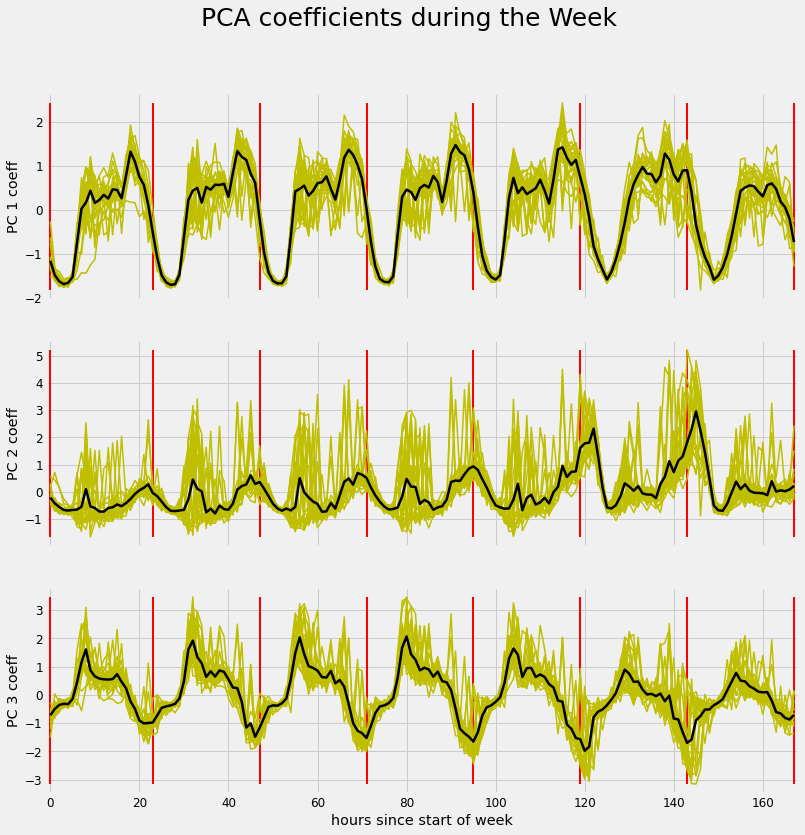

In [204]:
listOfFullWeeks = []
for uniqueVal in np.unique(weekOfYearVec):
    if (weekOfYearVec == uniqueVal).sum() == 24*7:
        listOfFullWeeks.append(uniqueVal)

weeklyTraces = np.zeros((24*7,numComponents,len(listOfFullWeeks)))
for k, weekInd in enumerate(listOfFullWeeks):
    weeklyTraces[:,:,k] = compactClusterDistributionHourOfYear[weekOfYearVec == weekInd,:]

fig, axArray = plt.subplots(nrows=numComponents,ncols=1,sharex=True, figsize=(12,12))
fig.suptitle('PCA coefficients during the Week', fontsize=25)
for PC_coeff in range(numComponents):
    meanTrace_week = weeklyTraces[:,PC_coeff,:].mean(axis=1)
    axArray[PC_coeff].plot(weeklyTraces[:,PC_coeff,:],'y',linewidth=1.5)
    axArray[PC_coeff].plot(meanTrace_week,'k',linewidth=2.5)
    axArray[PC_coeff].set_ylabel('PC %d coeff' %(PC_coeff+1))
    axArray[PC_coeff].vlines([0,23,47,71,95,119,143,167], weeklyTraces[:,PC_coeff,:].min(), weeklyTraces[:,PC_coeff,:].max(), colors='r', lw=2)
    
axArray[PC_coeff].set_xlabel('hours since start of week')
axArray[PC_coeff].set_xlim(-0.9,24*7-0.1)

もともとノートブックに書かれていたことではあるが、平日・休日で各要素の時間的変化に違いがあることが分かる。

- 本当はフーリエ変換をして、平日・休日に含まれる周波数の違いを特徴量として扱いたいと考えていた。
  - フーリエ変換：全ての周期的な信号は様々な周波数の正弦波の足し合わせであるという「フーリエ級数展開」という考え方がある。周期を無限大とみなし、正弦波の足し合わせを連続関数に変換したものがフーリエ変換である。[(参考)](http://www.ml.seikei.ac.jp/biolab/lecture/Bioelecronics/2.5Fourier.pdf)
- が、平日・休日に違いがあることだけ区別したいのであればフラグを足せばいいだけなので、今回はそのようにする(dayOfWeekなどと相関がある要素になるが、どのくらい影響があるか…)。ノートブックにあった分析はtrip durationを加えた上で平日・休日との周期性に違いを見出していたので、影響が大きいとみなし休日=0・平日=10で値を設定してみる。

In [236]:
taxiDB_train["flg_holiday"] = 10

In [237]:
taxiDB_train["flg_holiday"] = taxiDB_train['flg_holiday'].where(taxiDB_train['dayOfWeek'] < 5, 0)
taxiDB_train

vendor_id  passenger_count  src lat [km]  src long [km]  \
0                2                1      1.486707      -0.099721   
1                1                1     -1.783114       0.046965   
2                2                1      1.041672       0.164056   
3                2                1     -3.852868      -2.451197   
4                2                1      4.300027       0.667806   
...            ...              ...           ...            ...   
1420053          2                4     -1.008549      -0.103581   
1420054          1                1     -0.801743      -1.684313   
1420055          2                1      1.582678       1.841936   
1420056          1                1     -0.614472      -0.093287   
1420057          1                1      3.024372       0.120951   

         dst lat [km]  dst long [km]  euclidian distance  src hourOfDay  \
0            1.226820       1.378075            1.500473      17.400000   
1           -2.608213      -1.560788            1.807114       0.716667   
2           -4.953142      -2.054245            6.392077      11.583333   
3           -5.328110      -2.639058            1.487155      19.533333   
4            3.110152       0.678744            1.189925      13.500000   
...               ...            ...                 ...            ...   
1420053     -1.604336      -1.175417            1.226293      13.516667   
1420054      4.671598       0.909709            6.056931       7.583333   
1420055     -5.255494      -1.978328            7.832945       6.950000   
1420056      0.281120       0.534631            1.093785      15.933333   
1420057      4.007867       0.688394            1.135452      14.733333   

         dayOfWeek  hourOfWeek  monthOfYear  dayOfYear  weekOfYear  \
0                0   17.400000            3         74          11   
1                6  144.716667            6        164          23   
2                1   35.583333            1         19           3   
3                2   67.533333            4         97          14   
4                5  133.500000            3         86          12   
...            ...         ...          ...        ...         ...   
1420053          4  109.516667            4         99          14   
1420054          6  151.583333            1         10           1   
1420055          4  102.950000            4        113          16   
1420056          1   39.933333            1          5           1   
1420057          1   38.733333            4         96          14   

          hourOfYear  flg_holiday  
0        1793.400000           10  
1        3936.716667            0  
2         467.583333           10  
3        2347.533333           10  
4        2077.500000            0  
...              ...          ...  
1420053  2389.516667           10  
1420054   247.583333            0  
1420055  2718.950000           10  
1420056   135.933333           10  
1420057  2318.733333           10  

[1420058 rows x 15 columns]

In [238]:
X = taxiDB_train
y = taxiDB['trip_duration']
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=32)

(1420058, 15) (1420058,)


In [239]:
train_pool = Pool(X_train, y_train)
validate_pool = Pool(X_test, y_test)

cb_3 = CatBoostRegressor(learning_rate=1, depth=5, loss_function=RMSLE_loss(), eval_metric=RMSLE_metric(), iterations=300)
cb_3 = cb_3.fit(train_pool, eval_set=validate_pool, early_stopping_rounds=10, use_best_model=True)
y_pred_3 = cb_3.predict(X_test)
mean_squared_log_error(y_test, y_pred_3)

0:	learn: 5.8755870	test: 5.8734556	best: 5.8734556 (0)	total: 17.6s	remaining: 1h 27m 42s
1:	learn: 5.3364860	test: 5.3343844	best: 5.3343844 (1)	total: 35s	remaining: 1h 26m 51s
2:	learn: 4.8624831	test: 4.8603955	best: 4.8603955 (2)	total: 52.3s	remaining: 1h 26m 22s
3:	learn: 4.4425885	test: 4.4405675	best: 4.4405675 (3)	total: 1m 10s	remaining: 1h 26m 22s
4:	learn: 4.0686323	test: 4.0666377	best: 4.0666377 (4)	total: 1m 27s	remaining: 1h 26m 9s
5:	learn: 3.7335954	test: 3.7316245	best: 3.7316245 (5)	total: 1m 45s	remaining: 1h 26m 6s
6:	learn: 3.4332636	test: 3.4313658	best: 3.4313658 (6)	total: 2m 3s	remaining: 1h 26m 3s
7:	learn: 3.1622398	test: 3.1603802	best: 3.1603802 (7)	total: 2m 21s	remaining: 1h 25m 57s
8:	learn: 2.9188360	test: 2.9170279	best: 2.9170279 (8)	total: 2m 38s	remaining: 1h 25m 31s
9:	learn: 2.6969765	test: 2.6951865	best: 2.6951865 (9)	total: 2m 56s	remaining: 1h 25m 22s
10:	learn: 2.4968256	test: 2.4950461	best: 2.4950461 (10)	total: 3m 14s	remaining: 1h 25m

88:	learn: 0.4423096	test: 0.4420117	best: 0.4420117 (88)	total: 26m 6s	remaining: 1h 1m 53s
89:	learn: 0.4412494	test: 0.4409475	best: 0.4409475 (89)	total: 26m 24s	remaining: 1h 1m 36s
90:	learn: 0.4404229	test: 0.4401193	best: 0.4401193 (90)	total: 26m 41s	remaining: 1h 1m 18s
91:	learn: 0.4398338	test: 0.4395347	best: 0.4395347 (91)	total: 26m 59s	remaining: 1h 1m
92:	learn: 0.4388768	test: 0.4385700	best: 0.4385700 (92)	total: 27m 16s	remaining: 1h 42s
93:	learn: 0.4381094	test: 0.4378106	best: 0.4378106 (93)	total: 27m 33s	remaining: 1h 24s
94:	learn: 0.4375092	test: 0.4372140	best: 0.4372140 (94)	total: 27m 51s	remaining: 1h 6s
95:	learn: 0.4368288	test: 0.4365304	best: 0.4365304 (95)	total: 28m 8s	remaining: 59m 48s
96:	learn: 0.4362191	test: 0.4359201	best: 0.4359201 (96)	total: 28m 25s	remaining: 59m 29s
97:	learn: 0.4356344	test: 0.4353325	best: 0.4353325 (97)	total: 28m 42s	remaining: 59m 11s
98:	learn: 0.4349770	test: 0.4346687	best: 0.4346687 (98)	total: 29m	remaining: 58

176:	learn: 0.4142516	test: 0.4140103	best: 0.4140103 (176)	total: 51m 9s	remaining: 35m 32s
177:	learn: 0.4140174	test: 0.4137780	best: 0.4137780 (177)	total: 51m 26s	remaining: 35m 15s
178:	learn: 0.4137414	test: 0.4135078	best: 0.4135078 (178)	total: 51m 42s	remaining: 34m 57s
179:	learn: 0.4136943	test: 0.4134606	best: 0.4134606 (179)	total: 51m 59s	remaining: 34m 39s
180:	learn: 0.4134453	test: 0.4132092	best: 0.4132092 (180)	total: 52m 16s	remaining: 34m 22s
181:	learn: 0.4133781	test: 0.4131420	best: 0.4131420 (181)	total: 52m 33s	remaining: 34m 4s
182:	learn: 0.4133012	test: 0.4130659	best: 0.4130659 (182)	total: 52m 49s	remaining: 33m 46s
183:	learn: 0.4132563	test: 0.4130207	best: 0.4130207 (183)	total: 53m 6s	remaining: 33m 28s
184:	learn: 0.4131195	test: 0.4128822	best: 0.4128822 (184)	total: 53m 23s	remaining: 33m 11s
185:	learn: 0.4129657	test: 0.4127299	best: 0.4127299 (185)	total: 53m 40s	remaining: 32m 53s
186:	learn: 0.4129133	test: 0.4126768	best: 0.4126768 (186)	tot

263:	learn: 0.4060626	test: 0.4058763	best: 0.4058763 (263)	total: 1h 15m 34s	remaining: 10m 18s
264:	learn: 0.4059850	test: 0.4058032	best: 0.4058032 (264)	total: 1h 15m 51s	remaining: 10m 1s
265:	learn: 0.4058903	test: 0.4057101	best: 0.4057101 (265)	total: 1h 16m 7s	remaining: 9m 43s
266:	learn: 0.4058581	test: 0.4056792	best: 0.4056792 (266)	total: 1h 16m 25s	remaining: 9m 26s
267:	learn: 0.4058047	test: 0.4056249	best: 0.4056249 (267)	total: 1h 16m 41s	remaining: 9m 9s
268:	learn: 0.4057099	test: 0.4055294	best: 0.4055294 (268)	total: 1h 16m 58s	remaining: 8m 52s
269:	learn: 0.4055997	test: 0.4054200	best: 0.4054200 (269)	total: 1h 17m 15s	remaining: 8m 35s
270:	learn: 0.4055757	test: 0.4053954	best: 0.4053954 (270)	total: 1h 17m 32s	remaining: 8m 17s
271:	learn: 0.4055249	test: 0.4053439	best: 0.4053439 (271)	total: 1h 17m 49s	remaining: 8m
272:	learn: 0.4053972	test: 0.4052190	best: 0.4052190 (272)	total: 1h 18m 6s	remaining: 7m 43s
273:	learn: 0.4053277	test: 0.4051499	best: 0.

0.16283531555344383

In [240]:
testDB_drop["flg_holiday"] = 10
testDB_drop["flg_holiday"] = testDB_drop['flg_holiday'].where(testDB_drop['dayOfWeek'] < 5, 0)
testDB_drop

vendor_id  passenger_count  src lat [km]  src long [km]  dst lat [km]  \
0               1                1     -2.482941      -0.612480      0.261161   
1               1                1     -8.275620       1.405101    -11.012928   
2               1                1     -1.864647      -1.397381     -2.761937   
3               2                1      1.955523       2.090924     -2.656624   
4               1                1      0.794949       0.898132      0.173258   
...           ...              ...           ...            ...           ...   
625129          1                1     -3.253684      -1.905636     -2.303313   
625130          1                1     -1.174588      -2.150113      3.131809   
625131          1                2      0.615746       0.725068     -0.631033   
625132          1                1     -2.312231       0.368003     15.301489   
625133          2                2     -4.169234      -0.082994      1.674828   

        dst long [km]  euclidian distance  src hourOfDay  dayOfWeek  \
0           -0.784901            2.749513      23.983333          3   
1            1.775677            2.762278      23.983333          3   
2           -0.446493            1.307408      23.983333          3   
3           -0.469010            5.274956      23.983333          3   
4            1.632207            0.961959      23.983333          3   
...               ...                 ...            ...        ...   
625129      -1.719061            0.968512       0.033333          4   
625130       2.315457            6.203738       0.016667          4   
625131       8.792174            8.162883       0.016667          4   
625132      10.675936           20.408249       0.000000          4   
625133       0.972762            5.938660       0.000000          4   

        hourOfWeek  monthOfYear  dayOfYear  weekOfYear   hourOfYear  \
0        95.983333            6        182          26  4391.983333   
1        95.983333            6        182          26  4391.983333   
2        95.983333            6        182          26  4391.983333   
3        95.983333            6        182          26  4391.983333   
4        95.983333            6        182          26  4391.983333   
...            ...          ...        ...         ...          ...   
625129   96.033333            1          1          53    24.033333   
625130   96.016667            1          1          53    24.016667   
625131   96.016667            1          1          53    24.016667   
625132   96.000000            1          1          53    24.000000   
625133   96.000000            1          1          53    24.000000   

        flg_holiday  
0                10  
1                10  
2                10  
3                10  
4                10  
...             ...  
625129           10  
625130           10  
625131           10  
625132           10  
625133           10  

[625134 rows x 15 columns]

In [241]:
sub_pred = cb_3.predict(testDB_drop)

submission = pd.DataFrame()
submission['id'] = testDB.id.values
submission['trip_duration'] = sub_pred
submission.to_csv('submission_3.csv', index=False)

- Private Score:0.49127
- Public Score:0.49174

微々たる改善。

プライベートスコア順位(当時)：772/1254

## 考察・感想
- フーリエ変換で週全体の周波数の特性を観察すれば、平日毎に異なったパラメータが設定できるかもしれないと思った。
- 相関が強いと思われるパラメータの追加によるモデル改善はあまり期待できないということを改めて実感した。いろんなノートブックを見て観点を変えたパラメータを生成できるようになりたい。
- このノートブックについて、週ごとに周期性を確認したい意図があることは分かったが、なぜ次元削減したものでみようとしたのかが理解できなかった。単純に、少ない次元数だと視覚化しやすかったためだろうか？(削減した結果のパラメータに意味を見いだせないと活用が難しいと感じる)